# Cálculo para las tres primeras capas

## Constantes

In [4]:
#Definimos las constantes necesarias

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

MTot = 5  #masa total
LTot = 40 #luminosidd total
RTot = 12.0 #radio total
RIni = 0.9*RTot #radio inicial
num_capas = 101 #número de capas
X = 0.8 #contenido de hidrogeno
Y = 0.16 #contenido de helio
Z = 1-Y-X #elementos pesados
mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio

A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
Cp = 8.084*mu #cte para calcular f_i de las pres
Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp


h = -RIni/(num_capas-1) #paso de integración
ERelMax = 0.0001
X1_PP = X
X2_PP = X
X1_CN = X
X2_CN = Z / 3
rho = MTot / (4/3) * np.pi * RTot**3

T=np.zeros(num_capas)
Test=np.zeros(num_capas)
Tcal=np.zeros(num_capas)

P=np.zeros(num_capas)
Pest=np.zeros(num_capas)
Pcal=np.zeros(num_capas)

fp=np.zeros(num_capas)
ft=np.zeros(num_capas)
fm=np.zeros(num_capas)
fl=np.zeros(num_capas)


M=np.zeros(num_capas)
Mcal=np.zeros(num_capas)
Mest=np.zeros(num_capas)

L=np.zeros(num_capas)
Lcal=np.zeros(num_capas)
GenEnergiaPP=np.zeros(num_capas)
GenEnergiaCN=np.zeros(num_capas)

r = np.zeros(num_capas) #arrays vacios para almacenar los datos
n=np.zeros(num_capas)

novotny = np.ones(num_capas) * 2.5

In [5]:
DEBUG = False
#DEBUG = True

## Definiciones

In [6]:
def T_primeras_capas(A1, r, RTot):
    return A1*((1/r)-(1/RTot))

def P_primeras_capas(A2, T):
    return A2*T**(4.25)

def f_i_presion(Cp, P, T, MTot, r):
    return (-Cp*P*MTot)/(T*r**2)

def f_i_temperatura(Ct, P, LTot, T, r):
    return (-Ct*P**2*LTot)/(T**8.5*r**2)

## Bucle para las tres primeras capas

In [7]:
def Tres_primeras_capas(i):
    r[i]=RIni+(i*h)
    T[i]=T_primeras_capas(A1, r[i], RTot)
    P[i]=P_primeras_capas(A2, T[i])
    L[i]=LTot
    M[i]=MTot
    fp[i]=f_i_presion(Cp, P[i], T[i], MTot, r[i])
    ft[i]=f_i_temperatura(Ct, P[i], LTot, T[i], r[i])
    fm[i]=0.0
    fl[i]=0.0
    
    if DEBUG:
        print(f'i: {i}, fp[i]: {fp[i]}')
        print(f'i: {i}, ft[i]: {ft[i]}')
        print(f'i: {i}, fl[i]: {fl[i]}')
        print(f'i: {i}, fm[i]: {fm[i]}')  

In [8]:
i=-1

while i<=1:
    i += 1
    Tres_primeras_capas(i)
    print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
    
# Ya tenemos las tres primeras capas.              

  0 10.80000  0.0000576  0.0506120  40.000000   5.000000
  1 10.69200  0.0000867  0.0557243  40.000000   5.000000
  2 10.58400  0.0001268  0.0609409  40.000000   5.000000


## Integración envoltura radiativa

## 1 y 2.Definiciones de presión y temperatura y calculo del radio


In [9]:
def step_2(i):
    delta1_P = h * fp[i] - h * fp[i-1]
    delta2_P = h * fp[i] - 2 * h * fp[i-1] + h * fp[i-2]
    delta1_T = h * ft[i] - h * ft[i-1]
    
    Pest[i+1] = P[i] + h * fp[i] + 0.5 * delta1_P + 5 / 12 * delta2_P
    Test[i+1] = T[i] + h * ft[i] + 0.5 * delta1_T
    if DEBUG:
        print(f'step_2> delta1_P, delta2_P: {delta1_P}, {delta2_P}')
        print(f'step_2> Pest: {Pest[i+1]}')
        print(f'step_2> delta1_T: {delta1_T}')
        print(f'step_2> Test: {Test[i+1]}')


def step_3(i):
    fm[i+1] = 0.01523 * mu * (Pest[i+1] / Test[i+1]) * r[i+1]**2
    delta1_M = h * fm[i+1] - h * fm[i]
    Mcal[i+1] = M[i] + h * fm[i+1] - 0.5 * delta1_M
    if DEBUG:
        print(f'step_3> fm[i+1], fm[i]: {fm[i+1]}, {fm[i]}')
        print(f'step_3> employed P, T, r: {Pest[i+1]}, {Test[i+1]}, {r[i+1]}')
        print(f'step_3> delta1_M: {delta1_M}')
        print(f'step_3> Mcal[i+1]: {Mcal[i+1]}')
    

def step_4(i):
    fp[i+1] = -8.084 * mu * (Pest[i+1] / Test[i+1]) * (Mcal[i+1] / r[i+1]**2)
    deltai_P = h * fp[i+1] - h * fp[i] #delta P i+1
    Pcal[i+1] = P[i] + h * fp[i+1] - 0.5 * deltai_P
    if DEBUG:
        print(f'step_4> fp[i+1]: {fp[i+1]}')
        print(f'step_4> delta1_P: {deltai_P}')
        print(f'step_4> Pcal[i+1]: {Pcal[i+1]}')
    

def step_5(i):
    return abs(Pcal[i+1] - Pest[i+1]) / Pcal[i+1]
    
        
def GenEnergia(T):
    """T is given in units of 10**7 K"""
    # cycle PP
    TT = T*10 
    #print(TT)
    if 4 < TT <= 6:
        E1_PP = 10 ** -6.84
        nu_PP = 6
    elif  TT <= 9.5:
        E1_PP = 10 ** -6.04
        nu_PP = 5
    elif  TT <= 12:
        E1_PP = 10 ** -5.56
        nu_PP = 4.5
    elif  TT <= 16.5:
        E1_PP = 10 ** -5.02
        nu_PP = 4
    elif  TT <= 24:
        E1_PP = 10 ** -4.4
        nu_PP = 3.5
    else:
        E1_PP = 0
        nu_PP = 0

    # cycle CN
    if 12 < TT <= 16:
        E1_CN = 10 ** -22.2
        nu_CN = 20
    elif  TT <= 22.5:
        E1_CN = 10 ** -19.8
        nu_CN = 18
    elif  TT <= 27.5:
        E1_CN = 10 ** -17.1
        nu_CN = 16
    elif  TT <= 36:
        E1_CN = 10 ** -15.6
        nu_CN = 15
    elif TT <= 50:
        E1_CN = 10 ** -12.5
        nu_CN = 13
    else:
        E1_CN = 0
        nu_CN = 0

    # compute energy without the density (not necessary for the comparison)
    energy_PP = E1_PP * X1_PP * X2_PP * TT ** nu_PP
    energy_CN = E1_CN * X1_CN * X2_CN * TT ** nu_CN

    if energy_PP > energy_CN:
        return E1_PP, nu_PP, X1_PP, X2_PP
    else:
        return E1_CN, nu_CN, X1_CN, X2_CN

    
# quitar parámetros que son conocidos en el ámbito del módulo (variables definidas arriba del todo)

def step_6(i):
    E1, nu, X1, X2 = GenEnergia(Test[i+1])
    fl[i+1] = 0.01845 * E1 * X1 * X2 * 10**nu * mu**2 * Pcal[i+1]**2 * Test[i+1]**(nu-2) * r[i+1]**2
    delta1_L = h * fl[i+1] - h * fl[i]
    delta2_L = h * fl[i+1] - 2 * h * fl[i] + h * fl[i-1]
    Lcal[i+1] = L[i] + h * fl[i+1] - 0.5 * delta1_L - 1/12 * delta2_L
    if DEBUG:
        print(f'step_6> E1, nu, X1, X2: {E1}, {nu}, {X1}, {X2}')
        print(f'step_6> fl[i+1]: {fl[i+1]}')
        print(f'step_6> delta1_L: {delta1_L}')
        print(f'step_6> delta2_L: {delta2_L}')
        print(f'step_6> Lcal[i+1]: {Lcal[i+1]}')
    
    
def step_7(i):
    ft[i+1] = -0.01679 * Z * (1 + X) * mu**2 * (Pcal[i+1]**2 / Test[i+1]**8.5) * (Lcal[i+1] / r[i+1]**2)
    deltai_T = h * ft[i+1] - h * ft[i]
    Tcal[i+1] = T[i] + h * ft[i+1] - 0.5 * deltai_T
    if DEBUG:
        print(f'step_7> ft[i+1]: {ft[i+1]}')
        print(f'step_7> deltai_T: {deltai_T}')
        print(f'step_7> Tcal[i+1]: {Tcal[i+1]}')
    
    
def step_8(i):
    return abs(Tcal[i+1] - Test[i+1]) / Tcal[i+1]


def step_9(i):
    

    n[i+1] =   (Tcal[i+1] / Pcal [i+1]) * ((h * fp[i+1]) / (h * ft[i+1]))


def step_10(i):
    if n  <= 2.5:
        i = i + 1

In [10]:
#
# Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
#

i = 2  # número de la última capa calculada

Counter = []

print("-" * 78)
print("Algoritmo A.1.")
print("-" * 78)

# Utilizamos las variables lógicas loop1, loop2 y loop3
# para controlar cada uno de los bucle necesarios para
# programar el algoritmo de la fase A.1. (envoltura radiativa)

loop1 = True
while loop1:
    #print("\n*Calculando capa número:", i+1, "\n")
    #print("Ejecutando paso 1")
    r[i+1] = RIni+ (i+1)*h
    #print("Ejecutando paso 2")
    step_2(i)    
    loop2 = True
    while loop2:
        loop3 = True
        while loop3:
            #print("Ejecutando paso 3")
            step_3(i)
            #print("Ejecutando paso 4")
            step_4(i)
            
            #print(Pest[i+1], Pcal[i+1])
            diference = step_5(i)
            if diference < ERelMax:
                loop3 = False
            else:
                #print("Hacemos Pest = Pcal e iteramos loop3")
                Pest[i+1] = Pcal[i+1]
                #input('Press <CR> to continue...')
            
        #print("Ejecutando paso 6")
        
        step_6(i)
        
        #print("Ejecutando paso 7")
        step_7(i)
        
        diference = step_8(i)
        if diference < ERelMax:
            loop2 = False
        else:
            #print("Hacemos Tcal = Test e iteramos loop2")
            Test[i+1] = Tcal[i+1]
            #input('Press <CR> to continue...')

    #print("Ejecutando paso 9")
    step_9(i)
    
    decision = n[i+1]  
    if decision <= 2.5:
        loop1 = False
    else:
        # almacenamos los valores calculados y los mostramos
        P[i+1] = Pcal[i+1]
        T[i+1] = Tcal[i+1]
        L[i+1] = Lcal[i+1]
        M[i+1] = Mcal[i+1]
        print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

        # pasamos a la siguiente capa
        
        i += 1
        
        Counter.append(i)
        
    
    #input('Press <CR> to continue...')


print("-" * 78)
print("Pasamos a la fase convectiva, algoritmo A.2.")
print("-" * 78)


------------------------------------------------------------------------------
Algoritmo A.1.
------------------------------------------------------------------------------
  3 10.47600  0.0001814  0.0662729  40.000000   4.999858   4.238175
  4 10.36800  0.0002539  0.0717269  40.000000   4.999536   4.231392
  5 10.26000  0.0003490  0.0772998  40.000000   4.999132   4.231418
  6 10.15200  0.0004720  0.0829923  40.000000   4.998630   4.229411
  7 10.04400  0.0006293  0.0888060  40.000000   4.998015   4.232323
  8  9.93600  0.0008285  0.0947444  40.000000   4.997269   4.230808
  9  9.82800  0.0010783  0.1008110  40.000000   4.996373   4.234066
 10  9.72000  0.0013894  0.1070102  40.000000   4.995305   4.232361
 11  9.61200  0.0017738  0.1133464  40.000000   4.994041   4.235220
 12  9.50400  0.0022460  0.1198240  40.000000   4.992558   4.233490
 13  9.39600  0.0028224  0.1264479  40.000000   4.990826   4.235427
 14  9.28800  0.0035226  0.1332227  40.000000   4.988817   4.233943
 15  9.1800

In [11]:
print(f'{i+1:3d} {r[i+1]:8.5f} {Pest[i+1]:10.7f} {Test[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}')


 82  1.94400 36.5346138  1.3897200  37.035575   0.636305


In [12]:

last_layer = len(Counter) + 2
next_layer = len(Counter) + 3
x = r[last_layer]


## Nulceo convectivo

In [13]:
k = Pest[i+1] / (Test[i+1])**2.5
print(k)

def step_2_bis(i):
    delta1_T = h * ft[i] - h * ft[i-1]
    Test[i+1] = T[i] + h * ft[i] + 0.5 * delta1_T
    if DEBUG:
        print(f'step_2> ft[i],ft[i-1],ft[i+1]: {ft[i]},{ft[i-1]},{ft[i+1]}')
        print(f'step_2> delta1_T: {delta1_T}')
        print(f'step_2> Test: {Test[i+1]}')
    
def politropo_1(i):
    Pest[i+1] = k * Test[i+1] ** 2.5
    if DEBUG:
        print(f'politropo_1> Pest: {Pest[i+1]}')
        
        
def step_6_bis(i):
    E1, nu, X1, X2 = GenEnergia(Tcal[i+1])
    fl[i+1] = 0.01845 * E1 * X1 * X2 * 10**nu * mu**2 * Pcal[i+1]**2 * Tcal[i+1]**(nu-2) * r[i+1]**2
    delta1_L = h * fl[i+1] - h * fl[i]
    delta2_L = h * fl[i+1] - 2 * h * fl[i] + h * fl[i-1]
    Lcal[i+1] = L[i] + h * fl[i+1] - 0.5 * delta1_L - 1/12 * delta2_L
    if DEBUG:
        print(f'step_6> E1, nu, X1, X2: {E1}, {nu}, {X1}, {X2}')
        print(f'step_6> fl[i+1]: {fl[i+1]}')
        print(f'step_6> delta1_L: {delta1_L}')
        print(f'step_6> delta2_L: {delta2_L}')
        print(f'step_6> Lcal[i+1]: {Lcal[i+1]}')
        
def step_7_bis(i):
    if r[i+1] == 0:
        Tcal[i+1] = Test[i+1]
        
    else:
        ft[i+1] = -3.234 * mu * Mcal[i+1] / r[i+1]**2
        deltai_T = h * ft[i+1] - h * ft[i]
        Tcal[i+1] = T[i] + h * ft[i+1] - 0.5 * deltai_T
        
        
        if DEBUG:
            print(f'step_7> delta1_T: {deltai_T}')
            print(f'step_7> Tcal: {Tcal[i+1]}')
        
def politropo_2(i):
    Pcal[i+1] = k * Tcal[i+1] ** 2.5
    if DEBUG:
        print(f'politropo_2> Pcal: {Pcal[i+1]}')
        
def step_9_bis(i):
    
    if fp[i+1]==0:
        return 0.0
    else:
        n[i+1] =   (Tcal[i+1] / Pcal [i+1]) * ((h * fp[i+1]) / (h * ft[i+1]))
    
    
    
    
    

        

16.04671892286309


In [14]:
#
# Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
#

i = last_layer  # número de la última capa calculada

print("-" * 78)
print("Algoritmo A.2.")
print("-" * 78)

# Utilizamos las variables lógicas loop1, loop2 y loop3
# para controlar cada uno de los bucle necesarios para
# programar el algoritmo de la fase A.1. (envoltura radiativa)

loop1 = True
while loop1:
    #print("\n*Calculando capa número:", i+1, "\n")
    #print("Ejecutando paso 1")
    r[i+1] = RIni+(i+1) * h
    step_9_bis(i)
    #print("Ejecutando paso 2 bis")
    step_2_bis(i)
    
    loop2 = True
    while loop2:
        #print("Ejecutando polítropo 1")

        politropo_1(i)
            
        #print("Ejecutando paso 3")
        step_3(i)
            
            
        #print("Ejecutando paso 7 bis")
        
        step_7_bis(i)
        diference = step_8(i)
        if diference < ERelMax:
            loop2 = False
        else:
            #print("Hacemos Tcal = Test e iteramos loop2")
            Test[i+1] = Tcal[i+1]
    #print("Ejecutando polítropo 2")
    politropo_2(i)
    
    #print("Ejecutando paso 6")
    step_6_bis(i)
    
    
    decision = r[i+1]
    
    if decision <= 0:
        loop1 = False
    else:
        P[i+1] = Pcal[i+1]
        T[i+1] = Tcal[i+1]
        L[i+1] = Lcal[i+1]
        M[i+1] = Mcal[i+1]
        
        print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
        # pasamos a la siguiente capa
        i += 1

print("-" * 78)
print("Hemos llegado al nucleo de la estrella.")
print("-" * 78)

------------------------------------------------------------------------------
Algoritmo A.2.
------------------------------------------------------------------------------
 82  1.94400 36.5157135  1.3894324  37.035795   0.636320   2.456869
 83  1.83600 38.7332775  1.4225882  36.633918   0.545996   0.000000
 84  1.72800 40.9353506  1.4544035  36.214670   0.462890   0.000000
 85  1.62000 43.1055123  1.4847681  35.784965   0.387150   0.000000
 86  1.51200 45.2265895  1.5135718  35.352607   0.318846   0.000000
 87  1.40400 47.2807440  1.5407040  34.906741   0.257963   0.000000
 88  1.29600 49.2495193  1.5660524  34.389898   0.204402   0.000000
 89  1.18800 51.1138236  1.5895012  33.757186   0.157982   0.000000
 90  1.08000 52.8537863  1.6109273  33.038014   0.118441   0.000000
 91  0.97200 54.4483770  1.6301947  32.274919   0.085435   0.000000
 92  0.86400 55.8745712  1.6471425  31.503006   0.058550   0.000000
 93  0.75600 57.1055972  1.6615636  30.768526   0.037294   0.000000
 94  0.6480

## Interpolación 


In [15]:
# Empleamos la fórmula y=((x-x1)/(x2-x1)*(y2-y1))+ y1

In [16]:
r_int_d = ((2.5 - n[82]) / (n[81] - n[82]) * (r[81] - r[82])) + r[82]
P_int_d = ((2.5 - n[82]) / (n[81] - n[82]) * (P[81] - P[82])) + P[82]
T_int_d = ((2.5 - n[82]) / (n[81] - n[82]) * (T[81] - T[82])) + T[82]
L_int_d = ((2.5 - n[82]) / (n[81] - n[82]) * (L[81] - L[82])) + L[82]
M_int_d = ((2.5 - n[82]) / (n[81] - n[82]) * (M[81] - M[82])) + M[82]
print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


  1.98458    35.6890     1.3767     37.178     0.6729 


In [17]:
r_int_d = ((2.5 - n[last_layer]) / (n[next_layer] - n[last_layer]) * (r[next_layer] - r[last_layer])) + r[last_layer]
P_int_d = ((2.5 - n[last_layer]) / (n[next_layer] - n[last_layer]) * (P[next_layer] - P[last_layer])) + P[last_layer]
T_int_d = ((2.5 - n[last_layer]) / (n[next_layer] - n[last_layer]) * (T[next_layer] - T[last_layer])) + T[last_layer]
L_int_d = ((2.5 - n[last_layer]) / (n[next_layer] - n[last_layer]) * (L[next_layer] - L[last_layer])) + L[last_layer]
M_int_d = ((2.5 - n[last_layer]) / (n[next_layer] - n[last_layer]) * (M[next_layer] - M[last_layer])) + M[last_layer]
print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')

  1.98458    35.6890     1.3767     37.178     0.6729 


# Integración desde el centro

## Primeras tres capas

In [18]:
RIni = 0.0
h = -h #paso de integración
Tc = 1.5 #Temperatura en el centro

T=np.zeros(num_capas)
Test=np.zeros(num_capas)
Tcal=np.zeros(num_capas)

P=np.zeros(num_capas)
Pest=np.zeros(num_capas)
Pcal=np.zeros(num_capas)

fp=np.zeros(num_capas)
ft=np.zeros(num_capas)
fm=np.zeros(num_capas)
fl=np.zeros(num_capas)


M=np.zeros(num_capas)
Mcal=np.zeros(num_capas)
Mest=np.zeros(num_capas)

L=np.zeros(num_capas)
Lcal=np.zeros(num_capas)
GenEnergiaPP=np.zeros(num_capas)
GenEnergiaCN=np.zeros(num_capas)

r = np.zeros(num_capas) #arrays vacios para almacenar los datos


novotny = np.ones(num_capas) * 2.5


In [19]:
def M_tres_primeras_capas(Tc, mu, k,r):
    return 0.005077 * mu * k * np.power(Tc,1.5) *np.power(r,3)

def L_tres_primeras_capas(mu,k,Tc,r):
    E1, nu, X1, X2 = GenEnergia(Tc)
    return 0.00615 * E1 * X1 * X2 * 10**nu * mu**2 * k**2 * Tc**(3+nu) * r**3

def T_conveccion(Tc, mu, k,r):
    return Tc-0.008207 * mu**2 * k * Tc**1.5 * r**2

def P_tres_primeras_capas(k, T):
    return k * T**2.5

def fi_m_cen(k,T,r):
    Cm = 0.01523 * mu
    return Cm * k * T**1.5 * r**2

def fi_l_cen(k,T,r,mu):
    E1, nu, X1, X2 = GenEnergia(T)
    Cl_cen = 0.01845 * E1 * X1 * X2 * 10**nu * mu**2
    return Cl_cen * k**2 * T**(3+nu) * r**2

def fi_t_cen(M,r,mu):
    if r==0:
        return 0
    else:
        Ct_cen = 3.234 * mu
        return -Ct_cen * M / r**2

    
def fi_p_cen(k,T,M,r):
    if r==0:
        return 0 
    else:
        Cp = 8.084 * mu
        return -Cp * k * T**1.5 * M / r**2

    
def T_primeras_capas(A1, r, RTot):
    return A1*((1/r)-(1/RTot))

In [20]:
def Tres_primeras_capas_cen(i):
    r[i]=RIni+(i*h)
    M[i]=M_tres_primeras_capas(Tc, mu,k,r[i])
    L[i]=L_tres_primeras_capas(mu,k,Tc,r[i])
    T[i]=T_conveccion(Tc, mu, k, r[i])
    P[i]=P_tres_primeras_capas(k, T[i])
    fm[i]=fi_m_cen(k,T[i],r[i])
    fl[i]=fi_l_cen(k,T[i],r[i],mu)
    ft[i]=fi_t_cen(M[i],r[i],mu)
    fp[i]=fi_p_cen(k,T[i],M[i],r[i])
    
    
    

In [21]:
i=-1

while i<=1:
    i += 1
    Tres_primeras_capas_cen(i)
    print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
    #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')

  0  0.00000 44.2195576  1.5000000   0.000000   0.000000
  1  0.10800 44.1508954  1.4990679   0.000688   0.000108
  2  0.21600 43.9452930  1.4962717   0.005505   0.000867


## Capas posteriores

In [22]:
#
# Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
#

i = 2  # número de la última capa calculada
Counter = []
print("-" * 78)
print("Algoritmo A.2.")
print("-" * 78)

# Utilizamos las variables lógicas loop1, loop2 y loop3
# para controlar cada uno de los bucle necesarios para
# programar el algoritmo de la fase A.1. (envoltura radiativa)

loop1 = True
while loop1:
    #print("\n*Calculando capa número:", i+1, "\n")
    #print("Ejecutando paso 1")
    r[i+1] = RIni+(i+1) * h
    #print("Ejecutando paso 2 bis")
    step_2_bis(i)
    
    loop2 = True
    while loop2:
        #print("Ejecutando polítropo 1")

        politropo_1(i)
            
        #print("Ejecutando paso 3")
        step_3(i)
            
            
        #print("Ejecutando paso 7 bis")
        
        step_7_bis(i)
        diference = step_8(i)
        if diference < ERelMax:
            loop2 = False
        else:
            #print("Hacemos Tcal = Test e iteramos loop2")
            Test[i+1] = Tcal[i+1]
            #input('Press <CR> to continue...')
    #print("Ejecutando polítropo 2")
    politropo_2(i)
    #print("Ejecutando paso 6")
    step_6_bis(i)
    
    decision = r[i+1]
    if decision  >= 2.05300:
        loop1 = False
    else:
        P[i+1] = Pcal[i+1]
        T[i+1] = Tcal[i+1]
        L[i+1] = Lcal[i+1]
        M[i+1] = Mcal[i+1]
        print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
        # pasamos a la siguiente capa
        i += 1
        Counter.append(i)

print("-" * 78)
print("Hemos llegado a la zona radiativa.")
print("-" * 78)

------------------------------------------------------------------------------
Algoritmo A.2.
------------------------------------------------------------------------------
  3  0.32400 43.6010467  1.4915722   0.018184   0.002965
  4  0.43200 43.1212836  1.4849854   0.042241   0.006977
  5  0.54000 42.5140133  1.4765846   0.080534   0.013506
  6  0.64800 41.7852398  1.4664075   0.135209   0.023130
  7  0.75600 40.9413580  1.4544889   0.207603   0.036389
  8  0.86400 39.9895290  1.4408674   0.298208   0.053785
  9  0.97200 38.9376909  1.4255865   0.406669   0.075774
 10  1.08000 37.7944802  1.4086946   0.531844   0.102762
 11  1.18800 36.5691229  1.3902449   0.671891   0.135099
 12  1.29600 35.2713139  1.3702953   0.824396   0.173079
 13  1.40400 33.9110899  1.3489076   0.986517   0.216934
 14  1.51200 32.4987020  1.3261477   1.155146   0.266836
 15  1.62000 31.0444890  1.3020849   1.327069   0.322888
 16  1.72800 29.5587548  1.2767914   1.499115   0.385134
 17  1.83600 28.0516511  1.25

##  Interpolación 

In [23]:

last = len(Counter) + 2
prev = len(Counter) + 1

r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

  1.98458    35.6890     1.3767     37.178     0.6729 
  1.98458    25.9617     1.2121      1.890     0.5583 


In [24]:
err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')

#Como la luminosidad integrando desde el centro sale muy bajo, podemos usar una Tc más alta para reducir el error

 27.25567    11.9562    94.9154     17.034    100.920 


## Temperatura crítica $T_c=1.6$

In [42]:
RIni = 0.0
h = 0.108 #paso de integración
Tc = 1.7 #Temperatura en el centro

T=np.zeros(num_capas)
Test=np.zeros(num_capas)
Tcal=np.zeros(num_capas)

P=np.zeros(num_capas)
Pest=np.zeros(num_capas)
Pcal=np.zeros(num_capas)

fp=np.zeros(num_capas)
ft=np.zeros(num_capas)
fm=np.zeros(num_capas)
fl=np.zeros(num_capas)


M=np.zeros(num_capas)
Mcal=np.zeros(num_capas)
Mest=np.zeros(num_capas)

L=np.zeros(num_capas)
Lcal=np.zeros(num_capas)
GenEnergiaPP=np.zeros(num_capas)
GenEnergiaCN=np.zeros(num_capas)

r = np.zeros(num_capas) #arrays vacios para almacenar los datos


novotny = np.ones(num_capas) * 2.5
print(h)

0.108


In [43]:
i=-1

while i<=1:
    i += 1
    Tres_primeras_capas_cen(i)
    print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
    #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')

  0  0.00000 60.4656254  1.7000000   0.000000   0.000000
  1  0.10800 60.3656767  1.6988754   0.007696   0.000131
  2  0.21600 60.0664255  1.6955017   0.061570   0.001046


In [44]:
#
# Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
#

i = 2  # número de la última capa calculada
Counter = []
print("-" * 78)
print("Algoritmo A.2.")
print("-" * 78)

# Utilizamos las variables lógicas loop1, loop2 y loop3
# para controlar cada uno de los bucle necesarios para
# programar el algoritmo de la fase A.1. (envoltura radiativa)

loop1 = True
while loop1:
    #print("\n*Calculando capa número:", i+1, "\n")
    #print("Ejecutando paso 1")
    r[i+1] = RIni+(i+1) * h
    #print("Ejecutando paso 2 bis")
    step_2_bis(i)
    
    loop2 = True
    while loop2:
        #print("Ejecutando polítropo 1")

        politropo_1(i)
            
        #print("Ejecutando paso 3")
        step_3(i)
            
            
        #print("Ejecutando paso 7 bis")
        
        step_7_bis(i)
        diference = step_8(i)
        if diference < ERelMax:
            loop2 = False
        else:
            #print("Hacemos Tcal = Test e iteramos loop2")
            Test[i+1] = Tcal[i+1]
            #input('Press <CR> to continue...')
    #print("Ejecutando polítropo 2")
    politropo_2(i)
    #print("Ejecutando paso 6")
    step_6_bis(i)
    
    decision = r[i+1]
    if decision >= 2.053:
        loop1 = False
    else:
        P[i+1] = Pcal[i+1]
        T[i+1] = Tcal[i+1]
        L[i+1] = Lcal[i+1]
        M[i+1] = Mcal[i+1]
        print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
        # pasamos a la siguiente capa
        i += 1
        Counter.append(i)

print("-" * 78)
print("Hemos llegado a la zona convectiva.")
print("-" * 78)

------------------------------------------------------------------------------
Algoritmo A.2.
------------------------------------------------------------------------------
  3  0.32400 59.5655986  1.6898327   0.194244   0.003576
  4  0.43200 58.8680742  1.6818894   0.432020   0.008412
  5  0.54000 57.9858756  1.6717618   0.782611   0.016280
  6  0.64800 56.9282047  1.6594971   1.237444   0.027869
  7  0.75600 55.7049081  1.6451401   1.774272   0.043824
  8  0.86400 54.3270060  1.6287402   2.361774   0.064739
  9  0.97200 52.8066885  1.6103530   2.965047   0.091151
 10  1.08000 51.1571824  1.5900404   3.552383   0.123531
 11  1.18800 49.3925734  1.5678704   4.091141   0.162282
 12  1.29600 47.5276104  1.5439168   4.550829   0.207734
 13  1.40400 45.5775025  1.5182585   4.945724   0.260140
 14  1.51200 43.5577153  1.4909790   5.325666   0.319675
 15  1.62000 41.4837710  1.4621664   5.714435   0.386432
 16  1.72800 39.3710555  1.4319120   6.100109   0.460427
 17  1.83600 37.2346370  1.40

In [45]:
last = len(Counter) + 2
prev = len(Counter) + 1
r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
    #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

In [46]:
err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')

  3.93478     1.5989    81.2715      1.100     81.390 


## Temperatura crítica $T_c=1.86$

In [59]:
RIni = 0.0
h = 0.108 #paso de integración
Tc = 1.85 #Temperatura en el centro

T=np.zeros(num_capas)
Test=np.zeros(num_capas)
Tcal=np.zeros(num_capas)

P=np.zeros(num_capas)
Pest=np.zeros(num_capas)
Pcal=np.zeros(num_capas)

fp=np.zeros(num_capas)
ft=np.zeros(num_capas)
fm=np.zeros(num_capas)
fl=np.zeros(num_capas)


M=np.zeros(num_capas)
Mcal=np.zeros(num_capas)
Mest=np.zeros(num_capas)

L=np.zeros(num_capas)
Lcal=np.zeros(num_capas)
GenEnergiaPP=np.zeros(num_capas)
GenEnergiaCN=np.zeros(num_capas)

r = np.zeros(num_capas) #arrays vacios para almacenar los datos


novotny = np.ones(num_capas) * 2.5
print(h)

0.108


In [60]:

i=-1

while i<=1:
    i += 1
    Tres_primeras_capas_cen(i)
    print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
    #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')

  0  0.00000 74.6991339  1.8500000   0.000000   0.000000
  1  0.10800 74.5703278  1.8487233   0.045442   0.000148
  2  0.21600 74.1847096  1.8448933   0.363534   0.001187


In [61]:
#
# Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
#

i = 2  # número de la última capa calculada
Counter = []
print("-" * 78)
print("Algoritmo A.2.")
print("-" * 78)

# Utilizamos las variables lógicas loop1, loop2 y loop3
# para controlar cada uno de los bucle necesarios para
# programar el algoritmo de la fase A.1. (envoltura radiativa)

loop1 = True
while loop1:
    #print("\n*Calculando capa número:", i+1, "\n")
    #print("Ejecutando paso 1")
    r[i+1] = RIni+(i+1) * h
    #print("Ejecutando paso 2 bis")
    step_2_bis(i)
    
    loop2 = True
    while loop2:
        #print("Ejecutando polítropo 1")

        politropo_1(i)
            
        #print("Ejecutando paso 3")
        step_3(i)
            
            
        #print("Ejecutando paso 7 bis")
        
        step_7_bis(i)
        diference = step_8(i)
        if diference < ERelMax:
            loop2 = False
        else:
            #print("Hacemos Tcal = Test e iteramos loop2")
            Test[i+1] = Tcal[i+1]
            #input('Press <CR> to continue...')
    #print("Ejecutando polítropo 2")
    politropo_2(i)
    #print("Ejecutando paso 6")
    step_6_bis(i)
    
    decision = r[i+1]
    if decision >= 2.053:
        loop1 = False
    else:
        P[i+1] = Pcal[i+1]
        T[i+1] = Tcal[i+1]
        L[i+1] = Lcal[i+1]
        M[i+1] = Mcal[i+1]
        print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
        # pasamos a la siguiente capa
        i += 1
        Counter.append(i)

print("-" * 78)
print("Hemos llegado a la zona convectiva.")
print("-" * 78)

------------------------------------------------------------------------------
Algoritmo A.2.
------------------------------------------------------------------------------
  3  0.32400 73.5395385  1.8384586   1.143633   0.004059
  4  0.43200 72.6414005  1.8294443   2.536731   0.009546
  5  0.54000 71.5061227  1.8179536   4.580960   0.018469
  6  0.64800 70.1459849  1.8040419   7.217105   0.031607
  7  0.75600 68.5741658  1.7877621  10.306081   0.049686
  8  0.86400 66.8054068  1.7691724  13.658233   0.073370
  9  0.97200 64.8559898  1.7483386  17.067266   0.103258
 10  1.08000 62.7435472  1.7253338  20.341682   0.139871
 11  1.18800 60.4868147  1.7002383  23.328333   0.183650
 12  1.29600 58.1053604  1.6731388  25.925307   0.234950
 13  1.40400 55.6193061  1.6441284  28.084141   0.294036
 14  1.51200 53.0490488  1.6133052  29.803474   0.361083
 15  1.62000 50.4149880  1.5807725  31.114994   0.436171
 16  1.72800 47.7372660  1.5466374  32.059691   0.519289
 17  1.83600 45.0355226  1.51

In [62]:
last = len(Counter) + 2
prev = len(Counter) + 1

In [63]:
r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

  1.98458    35.6890     1.3767     37.178     0.6729 
  1.98458    41.3164     1.4596     33.558     0.7490 


In [64]:
err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')

 15.76789     6.0240     9.7368     11.314     22.533 


## Bucle para $T_c$ entre 1.8 y 1.87

In [36]:
RIni = 0.0
h = 0.108 #paso de integración


T=np.zeros(num_capas)
Test=np.zeros(num_capas)
Tcal=np.zeros(num_capas)

P=np.zeros(num_capas)
Pest=np.zeros(num_capas)
Pcal=np.zeros(num_capas)

fp=np.zeros(num_capas)
ft=np.zeros(num_capas)
fm=np.zeros(num_capas)
fl=np.zeros(num_capas)


M=np.zeros(num_capas)
Mcal=np.zeros(num_capas)
Mest=np.zeros(num_capas)

L=np.zeros(num_capas)
Lcal=np.zeros(num_capas)
GenEnergiaPP=np.zeros(num_capas)
GenEnergiaCN=np.zeros(num_capas)

r = np.zeros(num_capas) #arrays vacios para almacenar los datos


novotny = np.ones(num_capas) * 2.5
print(x)
print(h)

2.0519999999999996
0.108


In [37]:
def Tres_primeras_capas_cen(i):
    r[i]=RIni+(i*h)
    M[i]=M_tres_primeras_capas(Tc, mu,k,r[i])
    L[i]=L_tres_primeras_capas(mu,k,Tc,r[i])
    T[i]=T_conveccion(Tc, mu, k, r[i])
    P[i]=P_tres_primeras_capas(k, T[i])
    fm[i]=fi_m_cen(k,T[i],r[i])
    fl[i]=fi_l_cen(k,T[i],r[i],mu)
    ft[i]=fi_t_cen(M[i],r[i],mu)
    fp[i]=fi_p_cen(k,T[i],M[i],r[i])
    

In [38]:

Tc = 1.8
temp = []
ERROR = []
while Tc <=1.9:
    Tc += 0.0001
    
     #arrays vacios para almacenar los datos
    
    i=-1
    Counter = []

    while i<=1:
        i += 1
        Tres_primeras_capas_cen(i)
        #print(f'{Tc:8.5f} {i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
        #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        
    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')
        #print("Ejecutando polítropo 2")
        politropo_2(i)
        #print("Ejecutando paso 6")
        step_6_bis(i)

        decision = r[i+1]
        if decision >= 2.053:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{Tc:8.5f} {i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado a la zona convectiva.")
    #print("-" * 78)
    
    r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
    P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
    T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
    L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
    M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
    
    err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
    err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
    err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
    err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
    err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
    ERROR.append(err_Tot)
    temp.append(Tc)
    
    #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
        
        

21.65189399411307
1.8561999999999939


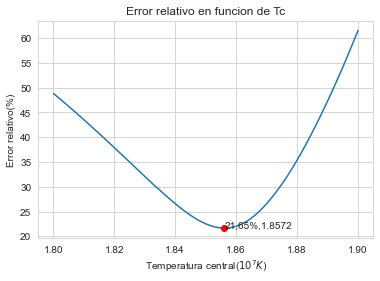

In [66]:
min_err = min(ERROR)
print(min_err)

index = ERROR.index(min(ERROR))
min_temp = temp[index]
print(min_temp)
sns.set_style("whitegrid")
plt.plot(temp,ERROR)
plt.plot(min_temp,min_err,marker='o',color='red')
plt.annotate("21,65%,1.8572",(min_temp,min_err))
plt.xlabel('Temperatura central($10^7 K$)')
plt.ylabel('Error relativo(%)')
plt.title('Error relativo en funcion de Tc')
plt.savefig('Errores.pdf')
plt.show()

## Modelo completo

In [40]:
RIni = 12
h  = -0.108
T=np.zeros(num_capas)
Test=np.zeros(num_capas)
Tcal=np.zeros(num_capas)

P=np.zeros(num_capas)
Pest=np.zeros(num_capas)
Pcal=np.zeros(num_capas)

fp=np.zeros(num_capas)
ft=np.zeros(num_capas)
fm=np.zeros(num_capas)
fl=np.zeros(num_capas)


M=np.zeros(num_capas)
Mcal=np.zeros(num_capas)
Mest=np.zeros(num_capas)

L=np.zeros(num_capas)
Lcal=np.zeros(num_capas)
GenEnergiaPP=np.zeros(num_capas)
GenEnergiaCN=np.zeros(num_capas)

r = np.zeros(num_capas) #arrays vacios para almacenar los datos
n=np.zeros(num_capas)
novotny = np.ones(num_capas) * 2.5

def Tres_primeras_capas(i):
    r[i]=RIni+(i*h)
    T[i]=T_primeras_capas(A1, r[i], RTot)
    P[i]=P_primeras_capas(A2, T[i])
    L[i]=LTot
    M[i]=MTot
    fp[i]=f_i_presion(Cp, P[i], T[i], MTot, r[i])
    ft[i]=f_i_temperatura(Ct, P[i], LTot, T[i], r[i])
    fm[i]=0.0
    fl[i]=0.0
    
    if DEBUG:
        print(f'i: {i}, fp[i]: {fp[i]}')
        print(f'i: {i}, ft[i]: {ft[i]}')
        print(f'i: {i}, fl[i]: {fl[i]}')
        print(f'i: {i}, fm[i]: {fm[i]}')  

In [41]:
i=-1
while i<=9:
    i += 1
    Tres_primeras_capas(i)
    print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')

  0 12.00000  0.0000000  0.0000000  40.000000   5.000000
  1 11.89200  0.0000000  0.0041368  40.000000   5.000000
  2 11.78400  0.0000000  0.0083494  40.000000   5.000000
  3 11.67600  0.0000002  0.0126400  40.000000   5.000000
  4 11.56800  0.0000006  0.0170107  40.000000   5.000000
  5 11.46000  0.0000015  0.0214637  40.000000   5.000000
  6 11.35200  0.0000034  0.0260015  40.000000   5.000000
  7 11.24400  0.0000068  0.0306264  40.000000   5.000000
  8 11.13600  0.0000125  0.0353411  40.000000   5.000000
  9 11.02800  0.0000215  0.0401481  40.000000   5.000000
 10 10.92000  0.0000351  0.0450502  40.000000   5.000000


<ipython-input-3-66b3623e0144>:8: RuntimeWarning: invalid value encountered in double_scalars
  return (-Cp*P*MTot)/(T*r**2)
<ipython-input-3-66b3623e0144>:11: RuntimeWarning: invalid value encountered in double_scalars
  return (-Ct*P**2*LTot)/(T**8.5*r**2)


In [42]:
MTot = 5  #masa total
LTot = 40 #luminosidd total
RTot = 12 #radio total
RIni = 0.9*RTot #radio inicial
num_capas = 101 #número de capas
X = 0.8 #contenido de hidrogeno
Y = 0.16 #contenido de helio
Z = 1-Y-X #elementos pesados
mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
Cp = 8.084*mu #cte para calcular f_i de las pres
Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
h = -RIni/(num_capas-1) #paso de integración
ERelMax = 0.0001
X1_PP = X
X2_PP = X
X1_CN = X
X2_CN = Z / 3
rho = MTot / (4/3) * np.pi * RTot**3

T=np.zeros(num_capas)
Test=np.zeros(num_capas)
Tcal=np.zeros(num_capas)

P=np.zeros(num_capas)
Pest=np.zeros(num_capas)
Pcal=np.zeros(num_capas)

fp=np.zeros(num_capas)
ft=np.zeros(num_capas)
fm=np.zeros(num_capas)
fl=np.zeros(num_capas)


M=np.zeros(num_capas)
Mcal=np.zeros(num_capas)
Mest=np.zeros(num_capas)

L=np.zeros(num_capas)
Lcal=np.zeros(num_capas)
GenEnergiaPP=np.zeros(num_capas)
GenEnergiaCN=np.zeros(num_capas)

r = np.zeros(num_capas) #arrays vacios para almacenar los datos
n=np.zeros(num_capas)
novotny = np.ones(num_capas) * 2.5

In [43]:
i=-1

while i<=1:
    i += 1
    Tres_primeras_capas(i)
    print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
    
# Ya tenemos las tres primeras capas.    


  0 10.80000  0.0000576  0.0506120  40.000000   5.000000
  1 10.69200  0.0000867  0.0557243  40.000000   5.000000
  2 10.58400  0.0001268  0.0609409  40.000000   5.000000


In [44]:
#
# Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
#

i = 2  # número de la última capa calculada

print("-" * 78)
print("Algoritmo A.1.")
print("-" * 78)

# Utilizamos las variables lógicas loop1, loop2 y loop3
# para controlar cada uno de los bucle necesarios para
# programar el algoritmo de la fase A.1. (envoltura radiativa)

loop1 = True
while loop1:
    #print("\n*Calculando capa número:", i+1, "\n")
    #print("Ejecutando paso 1")
    r[i+1] = RIni+ (i+1)*h
    #print("Ejecutando paso 2")
    step_2(i)    
    loop2 = True
    while loop2:
        loop3 = True
        while loop3:
            #print("Ejecutando paso 3")
            step_3(i)
            #print("Ejecutando paso 4")
            step_4(i)
            
            #print(Pest[i+1], Pcal[i+1])
            diference = step_5(i)
            if diference < ERelMax:
                loop3 = False
            else:
                #print("Hacemos Pest = Pcal e iteramos loop3")
                Pest[i+1] = Pcal[i+1]
                #input('Press <CR> to continue...')
            
        #print("Ejecutando paso 6")
        
        step_6(i)
        
        #print("Ejecutando paso 7")
        step_7(i)
        
        diference = step_8(i)
        if diference < ERelMax:
            loop2 = False
        else:
            #print("Hacemos Tcal = Test e iteramos loop2")
            Test[i+1] = Tcal[i+1]
            #input('Press <CR> to continue...')

    #print("Ejecutando paso 9")
    step_9(i)
    
    decision = n[i+1]  
    if decision <= 2.5:
        loop1 = False
    else:
        # almacenamos los valores calculados y los mostramos
        P[i+1] = Pcal[i+1]
        T[i+1] = Tcal[i+1]
        L[i+1] = Lcal[i+1]
        M[i+1] = Mcal[i+1]
        print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

        # pasamos a la siguiente capa
        i += 1
        
    
    #input('Press <CR> to continue...')


print("-" * 78)
print("Pasamos a la fase convectiva, algoritmo A.2.")
print("-" * 78)


------------------------------------------------------------------------------
Algoritmo A.1.
------------------------------------------------------------------------------
  3 10.47600  0.0001814  0.0662729  40.000000   4.999858   4.238175
  4 10.36800  0.0002539  0.0717269  40.000000   4.999536   4.231392
  5 10.26000  0.0003490  0.0772998  40.000000   4.999132   4.231418
  6 10.15200  0.0004720  0.0829923  40.000000   4.998630   4.229411
  7 10.04400  0.0006293  0.0888060  40.000000   4.998015   4.232323
  8  9.93600  0.0008285  0.0947444  40.000000   4.997269   4.230808
  9  9.82800  0.0010783  0.1008110  40.000000   4.996373   4.234066
 10  9.72000  0.0013894  0.1070102  40.000000   4.995305   4.232361
 11  9.61200  0.0017738  0.1133464  40.000000   4.994041   4.235220
 12  9.50400  0.0022460  0.1198240  40.000000   4.992558   4.233490
 13  9.39600  0.0028224  0.1264479  40.000000   4.990826   4.235427
 14  9.28800  0.0035226  0.1332227  40.000000   4.988817   4.233943
 15  9.1800

In [45]:
RIni = 0
h = 0.108 #paso de integración
Tc = temp[index] #Temperatura en el centro

T=np.zeros(num_capas)
Test=np.zeros(num_capas)
Tcal=np.zeros(num_capas)

P=np.zeros(num_capas)
Pest=np.zeros(num_capas)
Pcal=np.zeros(num_capas)

fp=np.zeros(num_capas)
ft=np.zeros(num_capas)
fm=np.zeros(num_capas)
fl=np.zeros(num_capas)


M=np.zeros(num_capas)
Mcal=np.zeros(num_capas)
Mest=np.zeros(num_capas)

L=np.zeros(num_capas)
Lcal=np.zeros(num_capas)
GenEnergiaPP=np.zeros(num_capas)
GenEnergiaCN=np.zeros(num_capas)

r = np.zeros(num_capas) #arrays vacios para almacenar los datos


novotny = np.ones(num_capas) * 2.5


In [46]:
i=-1

while i<=1:
    i += 1
    Tres_primeras_capas_cen(i)
    print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
    #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')

  0  0.00000 75.3265655  1.8562000   0.000000   0.000000
  1  0.10800 75.1964602  1.8549169   0.048749   0.000149
  2  0.21600 74.8069536  1.8510676   0.389995   0.001193


In [48]:
#
# Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
#

i = 2  # número de la última capa calculada

print("-" * 78)
print("Algoritmo A.2.")
print("-" * 78)

# Utilizamos las variables lógicas loop1, loop2 y loop3
# para controlar cada uno de los bucle necesarios para
# programar el algoritmo de la fase A.1. (envoltura radiativa)

loop1 = True
while loop1:
    #print("\n*Calculando capa número:", i+1, "\n")
    #print("Ejecutando paso 1")
    r[i+1] = RIni+(i+1) * h
    #print("Ejecutando paso 2 bis")
    step_2_bis(i)
    
    loop2 = True
    while loop2:
        #print("Ejecutando polítropo 1")

        politropo_1(i)
            
        #print("Ejecutando paso 3")
        step_3(i)
            
            
        #print("Ejecutando paso 7 bis")
        
        step_7_bis(i)
        diference = step_8(i)
        if diference < ERelMax:
            loop2 = False
        else:
            #print("Hacemos Tcal = Test e iteramos loop2")
            Test[i+1] = Tcal[i+1]
            #input('Press <CR> to continue...')
    #print("Ejecutando polítropo 2")
    politropo_2(i)
    #print("Ejecutando paso 6")
    step_6_bis(i)
    
    
    decision = r[i+1]
    if decision >= 2.053:
        loop1 = False
    else:
        P[i+1] = Pcal[i+1]
        T[i+1] = Tcal[i+1]
        L[i+1] = Lcal[i+1]
        M[i+1] = Mcal[i+1]
        print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} ') 
        # pasamos a la siguiente capa
        i += 1

print("-" * 78)
print("Hemos llegado a la zona convectiva.")
print("-" * 78)

------------------------------------------------------------------------------
Algoritmo A.2.
------------------------------------------------------------------------------
  3  0.32400 74.1552852  1.8446006   1.226734   0.004079 
  4  0.43200 73.2481194  1.8355410   2.720765   0.009594 
  5  0.54000 72.1014567  1.8239928   4.912676   0.018562 
  6  0.64800 70.7277179  1.8100116   7.738578   0.031765 
  7  0.75600 69.1402345  1.7936506  11.048940   0.049933 
  8  0.86400 67.3539185  1.7749685  14.640114   0.073734 
  9  0.97200 65.3852391  1.7540315  18.290797   0.103769 
 10  1.08000 63.2520306  1.7309132  21.795776   0.140560 
 11  1.18800 60.9732409  1.7056944  24.991157   0.184551 
 12  1.29600 58.5686581  1.6784624  27.768121   0.236096 
 13  1.40400 56.0586277  1.6493107  30.075206   0.295464 
 14  1.51200 53.4637710  1.6183384  31.911421   0.362826 
 15  1.62000 50.8047090  1.5856491  33.314204   0.438264 
 16  1.72800 48.1017988  1.5513509  34.328689   0.521764 
 17  1.83600 45

 ## Jugando con $R_{Tot}$ y $L_{Tot}$

##  $L_{Tot}=30$

In [49]:
errores = []

In [65]:
LTot = 28.5
while LTot <= 44:
    
    LTot += 1.5
    
    RTot = 11
    MTot = 5  #masa total
    RIni = 0.9*RTot #radio inicial
    num_capas = 101 #número de capas
    X = 0.8 #contenido de hidrogeno
    Y = 0.16 #contenido de helio
    Z = 1-Y-X #elementos pesados
    mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
    A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
    A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
    Cp = 8.084*mu #cte para calcular f_i de las pres
    Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
    h = -RIni/(num_capas-1) #paso de integración
    ERelMax = 0.0001
    X1_PP = X
    X2_PP = X
    X1_CN = X
    X2_CN = Z / 3
    rho = MTot / (4/3) * np.pi * RTot**3

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos
    n=np.zeros(num_capas)

    novotny = np.ones(num_capas) * 2.5

    i=-1

    while i<=1:
        i += 1
        Tres_primeras_capas(i)
        #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')



    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.1.")
    #print("-" * 78)
    Counter = []
    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+ (i+1)*h
        #print("Ejecutando paso 2")
        step_2(i)    
        loop2 = True
        while loop2:
            loop3 = True
            while loop3:
                #print("Ejecutando paso 3")
                step_3(i)
                #print("Ejecutando paso 4")
                step_4(i)

                #print(Pest[i+1], Pcal[i+1])
                diference = step_5(i)
                if diference < ERelMax:
                    loop3 = False
                else:
                    #print("Hacemos Pest = Pcal e iteramos loop3")
                    Pest[i+1] = Pcal[i+1]
                    #input('Press <CR> to continue...')

            #print("Ejecutando paso 6")

            step_6(i)

            #print("Ejecutando paso 7")
            step_7(i)

            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')

        #print("Ejecutando paso 9")
        step_9(i)

        decision = n[i+1]  
        if decision <= 2.5:
            loop1 = False
        else:
            # almacenamos los valores calculados y los mostramos
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

            # pasamos a la siguiente capa
            i += 1
            Counter.append(i)



        #input('Press <CR> to continue...')


    #print("-" * 78)
    #print("Pasamos a la fase convectiva, algoritmo A.2.")
    #print("-" * 78)


    # Ya tenemos las tres primeras capas.   

    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #
    last_layer = len(Counter) + 2
    next_layer = len(Counter) + 3
    x = r[last_layer]
    #print(x)
    i = last_layer  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        step_9_bis(i)
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
        #print("Ejecutando polítropo 2")
        politropo_2(i)

        #print("Ejecutando paso 6")
        step_6_bis(i)


        decision = r[i+1]

        if decision <= 0:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]

            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado al nucleo de la estrella.")
    #print("-" * 78)

    r_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last_layer] - r[next_layer])) + r[next_layer]
    P_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last_layer] - P[next_layer])) + P[next_layer]
    T_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last_layer] - T[next_layer])) + T[next_layer]
    L_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last_layer] - L[next_layer])) + L[next_layer]
    M_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last_layer] - M[next_layer])) + M[next_layer]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


    RIni = 0.0
    h = -h #paso de integración

    

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos

    Tc = 1.8
    temp = []
    ERROR = []
    while Tc <=1.9:
        Tc += 0.0001
        i=-1

        while i<=1:
            i += 1
            Tres_primeras_capas_cen(i)
            #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
            #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        #
        # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
        #

        i = 2  # número de la última capa calculada
        Counter = []
        #print("-" * 78)
        #print("Algoritmo A.2.")
        #print("-" * 78)

        # Utilizamos las variables lógicas loop1, loop2 y loop3
        # para controlar cada uno de los bucle necesarios para
        # programar el algoritmo de la fase A.1. (envoltura radiativa)

        loop1 = True
        while loop1:
            #print("\n*Calculando capa número:", i+1, "\n")
            #print("Ejecutando paso 1")
            r[i+1] = RIni+(i+1) * h
            #print("Ejecutando paso 2 bis")
            step_2_bis(i)

            loop2 = True
            while loop2:
                #print("Ejecutando polítropo 1")

                politropo_1(i)

                #print("Ejecutando paso 3")
                step_3(i)


                #print("Ejecutando paso 7 bis")

                step_7_bis(i)
                diference = step_8(i)
                if diference < ERelMax:
                    loop2 = False
                else:
                    #print("Hacemos Tcal = Test e iteramos loop2")
                    Test[i+1] = Tcal[i+1]
                    #input('Press <CR> to continue...')
            #print("Ejecutando polítropo 2")
            politropo_2(i)
            #print("Ejecutando paso 6")
            step_6_bis(i)

            decision = r[i+1]
            if decision >= 2.053:
                loop1 = False
            else:
                P[i+1] = Pcal[i+1]
                T[i+1] = Tcal[i+1]
                L[i+1] = Lcal[i+1]
                M[i+1] = Mcal[i+1]
                #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
                # pasamos a la siguiente capa
                i += 1
                Counter.append(i)


        #print("-" * 78)
        #print("Hemos llegado a la zona convectiva.")
        #print("-" * 78)

        last = len(Counter) + 2
        prev = len(Counter) + 1
        r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
    P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
    T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
    L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
    M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
            #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
        #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

    err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
    err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
    err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
    err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
    err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
    ERROR.append(err_Tot)
    temp.append(Tc)
    
        #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
    print(f'{LTot:8.1f} {min(ERROR):8.2f} ')
    
   
    

<ipython-input-10-43b847f0c712>:13: RuntimeWarning: invalid value encountered in double_scalars
  Pest[i+1] = k * Test[i+1] ** 2.5
<ipython-input-10-43b847f0c712>:46: RuntimeWarning: invalid value encountered in double_scalars
  Pcal[i+1] = k * Tcal[i+1] ** 2.5


    30.0   114.72 
    31.5   107.12 
    33.0    94.89 
    34.5    88.04 
    36.0    79.39 
    37.5    72.78 
    39.0    68.51 
    40.5    61.82 
    42.0    62.82 
    43.5    56.14 
    45.0    63.22 


In [66]:
LTot = 28.5
while LTot <= 44:
    
    LTot += 1.5
    
    RTot = 11.1
    MTot = 5  #masa total
    RIni = 0.9*RTot #radio inicial
    num_capas = 101 #número de capas
    X = 0.8 #contenido de hidrogeno
    Y = 0.16 #contenido de helio
    Z = 1-Y-X #elementos pesados
    mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
    A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
    A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
    Cp = 8.084*mu #cte para calcular f_i de las pres
    Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
    h = -RIni/(num_capas-1) #paso de integración
    ERelMax = 0.0001
    X1_PP = X
    X2_PP = X
    X1_CN = X
    X2_CN = Z / 3
    rho = MTot / (4/3) * np.pi * RTot**3

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos
    n=np.zeros(num_capas)

    novotny = np.ones(num_capas) * 2.5

    i=-1

    while i<=1:
        i += 1
        Tres_primeras_capas(i)
        #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')



    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.1.")
    #print("-" * 78)
    Counter = []
    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+ (i+1)*h
        #print("Ejecutando paso 2")
        step_2(i)    
        loop2 = True
        while loop2:
            loop3 = True
            while loop3:
                #print("Ejecutando paso 3")
                step_3(i)
                #print("Ejecutando paso 4")
                step_4(i)

                #print(Pest[i+1], Pcal[i+1])
                diference = step_5(i)
                if diference < ERelMax:
                    loop3 = False
                else:
                    #print("Hacemos Pest = Pcal e iteramos loop3")
                    Pest[i+1] = Pcal[i+1]
                    #input('Press <CR> to continue...')

            #print("Ejecutando paso 6")

            step_6(i)

            #print("Ejecutando paso 7")
            step_7(i)

            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')

        #print("Ejecutando paso 9")
        step_9(i)

        decision = n[i+1]  
        if decision <= 2.5:
            loop1 = False
        else:
            # almacenamos los valores calculados y los mostramos
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

            # pasamos a la siguiente capa
            i += 1
            Counter.append(i)



        #input('Press <CR> to continue...')


    #print("-" * 78)
    #print("Pasamos a la fase convectiva, algoritmo A.2.")
    #print("-" * 78)


    # Ya tenemos las tres primeras capas.   

    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #
    last_layer = len(Counter) + 2
    next_layer = len(Counter) + 3
    x = r[last_layer]
    #print(x)
    i = last_layer  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        step_9_bis(i)
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
        #print("Ejecutando polítropo 2")
        politropo_2(i)

        #print("Ejecutando paso 6")
        step_6_bis(i)


        decision = r[i+1]

        if decision <= 0:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]

            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado al nucleo de la estrella.")
    #print("-" * 78)

    r_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last_layer] - r[next_layer])) + r[next_layer]
    P_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last_layer] - P[next_layer])) + P[next_layer]
    T_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last_layer] - T[next_layer])) + T[next_layer]
    L_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last_layer] - L[next_layer])) + L[next_layer]
    M_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last_layer] - M[next_layer])) + M[next_layer]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


    RIni = 0.0
    h = -h #paso de integración

    

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos

    Tc = 1.8
    temp = []
    ERROR = []
    while Tc <=1.9:
        Tc += 0.0001
        i=-1

        while i<=1:
            i += 1
            Tres_primeras_capas_cen(i)
            #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
            #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        #
        # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
        #

        i = 2  # número de la última capa calculada
        Counter = []
        #print("-" * 78)
        #print("Algoritmo A.2.")
        #print("-" * 78)

        # Utilizamos las variables lógicas loop1, loop2 y loop3
        # para controlar cada uno de los bucle necesarios para
        # programar el algoritmo de la fase A.1. (envoltura radiativa)

        loop1 = True
        while loop1:
            #print("\n*Calculando capa número:", i+1, "\n")
            #print("Ejecutando paso 1")
            r[i+1] = RIni+(i+1) * h
            #print("Ejecutando paso 2 bis")
            step_2_bis(i)

            loop2 = True
            while loop2:
                #print("Ejecutando polítropo 1")

                politropo_1(i)

                #print("Ejecutando paso 3")
                step_3(i)


                #print("Ejecutando paso 7 bis")

                step_7_bis(i)
                diference = step_8(i)
                if diference < ERelMax:
                    loop2 = False
                else:
                    #print("Hacemos Tcal = Test e iteramos loop2")
                    Test[i+1] = Tcal[i+1]
                    #input('Press <CR> to continue...')
            #print("Ejecutando polítropo 2")
            politropo_2(i)
            #print("Ejecutando paso 6")
            step_6_bis(i)

            decision = r[i+1]
            if decision >= 2.053:
                loop1 = False
            else:
                P[i+1] = Pcal[i+1]
                T[i+1] = Tcal[i+1]
                L[i+1] = Lcal[i+1]
                M[i+1] = Mcal[i+1]
                #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
                # pasamos a la siguiente capa
                i += 1
                Counter.append(i)


        #print("-" * 78)
        #print("Hemos llegado a la zona convectiva.")
        #print("-" * 78)

        last = len(Counter) + 2
        prev = len(Counter) + 1
        r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
        P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
        T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
        L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
        M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
        #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
        #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

        err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
        err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
        err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
        err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
        err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
        ERROR.append(err_Tot)
        temp.append(Tc)
        #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
    print(f'{LTot:8.1f} {min(ERROR):8.2f} ')
    

<ipython-input-10-43b847f0c712>:13: RuntimeWarning: invalid value encountered in double_scalars
  Pest[i+1] = k * Test[i+1] ** 2.5
<ipython-input-10-43b847f0c712>:46: RuntimeWarning: invalid value encountered in double_scalars
  Pcal[i+1] = k * Tcal[i+1] ** 2.5


    30.0    27.75 
    31.5    32.96 
    33.0    16.27 
    34.5    20.55 
    36.0     8.00 
    37.5     8.94 
    39.0    13.53 
    40.5     8.21 
    42.0    25.17 
    43.5    19.66 
    45.0    37.30 


In [67]:
LTot = 28.5
while LTot <= 44:
    
    LTot += 1.5
    
    RTot = 11.2
    MTot = 5  #masa total
    RIni = 0.9*RTot #radio inicial
    num_capas = 101 #número de capas
    X = 0.8 #contenido de hidrogeno
    Y = 0.16 #contenido de helio
    Z = 1-Y-X #elementos pesados
    mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
    A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
    A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
    Cp = 8.084*mu #cte para calcular f_i de las pres
    Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
    h = -RIni/(num_capas-1) #paso de integración
    ERelMax = 0.0001
    X1_PP = X
    X2_PP = X
    X1_CN = X
    X2_CN = Z / 3
    rho = MTot / (4/3) * np.pi * RTot**3

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos
    n=np.zeros(num_capas)

    novotny = np.ones(num_capas) * 2.5

    i=-1

    while i<=1:
        i += 1
        Tres_primeras_capas(i)
        #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')



    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.1.")
    #print("-" * 78)
    Counter = []
    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+ (i+1)*h
        #print("Ejecutando paso 2")
        step_2(i)    
        loop2 = True
        while loop2:
            loop3 = True
            while loop3:
                #print("Ejecutando paso 3")
                step_3(i)
                #print("Ejecutando paso 4")
                step_4(i)

                #print(Pest[i+1], Pcal[i+1])
                diference = step_5(i)
                if diference < ERelMax:
                    loop3 = False
                else:
                    #print("Hacemos Pest = Pcal e iteramos loop3")
                    Pest[i+1] = Pcal[i+1]
                    #input('Press <CR> to continue...')

            #print("Ejecutando paso 6")

            step_6(i)

            #print("Ejecutando paso 7")
            step_7(i)

            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')

        #print("Ejecutando paso 9")
        step_9(i)

        decision = n[i+1]  
        if decision <= 2.5:
            loop1 = False
        else:
            # almacenamos los valores calculados y los mostramos
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

            # pasamos a la siguiente capa
            i += 1
            Counter.append(i)



        #input('Press <CR> to continue...')


    #print("-" * 78)
    #print("Pasamos a la fase convectiva, algoritmo A.2.")
    #print("-" * 78)


    # Ya tenemos las tres primeras capas.   

    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #
    last_layer = len(Counter) + 2
    next_layer = len(Counter) + 3
    x = r[last_layer]
    #print(x)
    i = last_layer  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        step_9_bis(i)
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
        #print("Ejecutando polítropo 2")
        politropo_2(i)

        #print("Ejecutando paso 6")
        step_6_bis(i)


        decision = r[i+1]

        if decision <= 0:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]

            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado al nucleo de la estrella.")
    #print("-" * 78)

    r_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last_layer] - r[next_layer])) + r[next_layer]
    P_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last_layer] - P[next_layer])) + P[next_layer]
    T_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last_layer] - T[next_layer])) + T[next_layer]
    L_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last_layer] - L[next_layer])) + L[next_layer]
    M_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last_layer] - M[next_layer])) + M[next_layer]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


    RIni = 0.0
    h = -h #paso de integración

    

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos

    Tc = 1.8
    temp = []
    ERROR = []
    while Tc <=1.9:
        Tc += 0.0001
        i=-1

        while i<=1:
            i += 1
            Tres_primeras_capas_cen(i)
            #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
            #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        #
        # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
        #

        i = 2  # número de la última capa calculada
        Counter = []
        #print("-" * 78)
        #print("Algoritmo A.2.")
        #print("-" * 78)

        # Utilizamos las variables lógicas loop1, loop2 y loop3
        # para controlar cada uno de los bucle necesarios para
        # programar el algoritmo de la fase A.1. (envoltura radiativa)

        loop1 = True
        while loop1:
            #print("\n*Calculando capa número:", i+1, "\n")
            #print("Ejecutando paso 1")
            r[i+1] = RIni+(i+1) * h
            #print("Ejecutando paso 2 bis")
            step_2_bis(i)

            loop2 = True
            while loop2:
                #print("Ejecutando polítropo 1")

                politropo_1(i)

                #print("Ejecutando paso 3")
                step_3(i)


                #print("Ejecutando paso 7 bis")

                step_7_bis(i)
                diference = step_8(i)
                if diference < ERelMax:
                    loop2 = False
                else:
                    #print("Hacemos Tcal = Test e iteramos loop2")
                    Test[i+1] = Tcal[i+1]
                    #input('Press <CR> to continue...')
            #print("Ejecutando polítropo 2")
            politropo_2(i)
            #print("Ejecutando paso 6")
            step_6_bis(i)

            decision = r[i+1]
            if decision >= 2.053:
                loop1 = False
            else:
                P[i+1] = Pcal[i+1]
                T[i+1] = Tcal[i+1]
                L[i+1] = Lcal[i+1]
                M[i+1] = Mcal[i+1]
                #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
                # pasamos a la siguiente capa
                i += 1
                Counter.append(i)


        #print("-" * 78)
        #print("Hemos llegado a la zona convectiva.")
        #print("-" * 78)

        last = len(Counter) + 2
        prev = len(Counter) + 1
        r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
        P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
        T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
        L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
        M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
        #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
        #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

        err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
        err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
        err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
        err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
        err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
        ERROR.append(err_Tot)
        temp.append(Tc)
        #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
    print(f'{LTot:8.1f} {min(ERROR):8.2f} ')
    

<ipython-input-10-43b847f0c712>:13: RuntimeWarning: invalid value encountered in double_scalars
  Pest[i+1] = k * Test[i+1] ** 2.5
<ipython-input-10-43b847f0c712>:46: RuntimeWarning: invalid value encountered in double_scalars
  Pcal[i+1] = k * Tcal[i+1] ** 2.5


    30.0    29.75 
    31.5    33.99 
    33.0    18.34 
    34.5    21.60 
    36.0    10.50 
    37.5    10.61 
    39.0    14.80 
    40.5    10.00 
    42.0    25.97 
    43.5    20.85 
    45.0    38.46 


In [68]:
LTot = 28.5
while LTot <= 44:
    
    LTot += 1.5
    
    RTot = 11.3
    MTot = 5  #masa total
    RIni = 0.9*RTot #radio inicial
    num_capas = 101 #número de capas
    X = 0.8 #contenido de hidrogeno
    Y = 0.16 #contenido de helio
    Z = 1-Y-X #elementos pesados
    mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
    A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
    A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
    Cp = 8.084*mu #cte para calcular f_i de las pres
    Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
    h = -RIni/(num_capas-1) #paso de integración
    ERelMax = 0.0001
    X1_PP = X
    X2_PP = X
    X1_CN = X
    X2_CN = Z / 3
    rho = MTot / (4/3) * np.pi * RTot**3

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos
    n=np.zeros(num_capas)

    novotny = np.ones(num_capas) * 2.5

    i=-1

    while i<=1:
        i += 1
        Tres_primeras_capas(i)
        #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')



    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.1.")
    #print("-" * 78)
    Counter = []
    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+ (i+1)*h
        #print("Ejecutando paso 2")
        step_2(i)    
        loop2 = True
        while loop2:
            loop3 = True
            while loop3:
                #print("Ejecutando paso 3")
                step_3(i)
                #print("Ejecutando paso 4")
                step_4(i)

                #print(Pest[i+1], Pcal[i+1])
                diference = step_5(i)
                if diference < ERelMax:
                    loop3 = False
                else:
                    #print("Hacemos Pest = Pcal e iteramos loop3")
                    Pest[i+1] = Pcal[i+1]
                    #input('Press <CR> to continue...')

            #print("Ejecutando paso 6")

            step_6(i)

            #print("Ejecutando paso 7")
            step_7(i)

            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')

        #print("Ejecutando paso 9")
        step_9(i)

        decision = n[i+1]  
        if decision <= 2.5:
            loop1 = False
        else:
            # almacenamos los valores calculados y los mostramos
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

            # pasamos a la siguiente capa
            i += 1
            Counter.append(i)



        #input('Press <CR> to continue...')


    #print("-" * 78)
    #print("Pasamos a la fase convectiva, algoritmo A.2.")
    #print("-" * 78)


    # Ya tenemos las tres primeras capas.   

    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #
    last_layer = len(Counter) + 2
    next_layer = len(Counter) + 3
    x = r[last_layer]
    #print(x)
    i = last_layer  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        step_9_bis(i)
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
        #print("Ejecutando polítropo 2")
        politropo_2(i)

        #print("Ejecutando paso 6")
        step_6_bis(i)


        decision = r[i+1]

        if decision <= 0:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]

            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado al nucleo de la estrella.")
    #print("-" * 78)

    r_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last_layer] - r[next_layer])) + r[next_layer]
    P_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last_layer] - P[next_layer])) + P[next_layer]
    T_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last_layer] - T[next_layer])) + T[next_layer]
    L_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last_layer] - L[next_layer])) + L[next_layer]
    M_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last_layer] - M[next_layer])) + M[next_layer]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


    RIni = 0.0
    h = -h #paso de integración

    

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos

    Tc = 1.8
    temp = []
    ERROR = []
    while Tc <=1.9:
        Tc += 0.0001
        i=-1

        while i<=1:
            i += 1
            Tres_primeras_capas_cen(i)
            #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
            #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        #
        # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
        #

        i = 2  # número de la última capa calculada
        Counter = []
        #print("-" * 78)
        #print("Algoritmo A.2.")
        #print("-" * 78)

        # Utilizamos las variables lógicas loop1, loop2 y loop3
        # para controlar cada uno de los bucle necesarios para
        # programar el algoritmo de la fase A.1. (envoltura radiativa)

        loop1 = True
        while loop1:
            #print("\n*Calculando capa número:", i+1, "\n")
            #print("Ejecutando paso 1")
            r[i+1] = RIni+(i+1) * h
            #print("Ejecutando paso 2 bis")
            step_2_bis(i)

            loop2 = True
            while loop2:
                #print("Ejecutando polítropo 1")

                politropo_1(i)

                #print("Ejecutando paso 3")
                step_3(i)


                #print("Ejecutando paso 7 bis")

                step_7_bis(i)
                diference = step_8(i)
                if diference < ERelMax:
                    loop2 = False
                else:
                    #print("Hacemos Tcal = Test e iteramos loop2")
                    Test[i+1] = Tcal[i+1]
                    #input('Press <CR> to continue...')
            #print("Ejecutando polítropo 2")
            politropo_2(i)
            #print("Ejecutando paso 6")
            step_6_bis(i)

            decision = r[i+1]
            if decision >= 2.053:
                loop1 = False
            else:
                P[i+1] = Pcal[i+1]
                T[i+1] = Tcal[i+1]
                L[i+1] = Lcal[i+1]
                M[i+1] = Mcal[i+1]
                #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
                # pasamos a la siguiente capa
                i += 1
                Counter.append(i)


        #print("-" * 78)
        #print("Hemos llegado a la zona convectiva.")
        #print("-" * 78)

        last = len(Counter) + 2
        prev = len(Counter) + 1
        r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
        P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
        T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
        L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
        M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
        #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
        #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

        err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
        err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
        err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
        err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
        err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
        ERROR.append(err_Tot)
        temp.append(Tc)
        #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
    print(f'{LTot:8.1f} {min(ERROR):8.2f} ')
    

<ipython-input-10-43b847f0c712>:13: RuntimeWarning: invalid value encountered in double_scalars
  Pest[i+1] = k * Test[i+1] ** 2.5
<ipython-input-10-43b847f0c712>:46: RuntimeWarning: invalid value encountered in double_scalars
  Pcal[i+1] = k * Tcal[i+1] ** 2.5


    30.0    31.89 
    31.5    35.15 
    33.0    20.57 
    34.5    22.84 
    36.0    13.11 
    37.5    12.52 
    39.0    16.43 
    40.5    12.00 
    42.0    27.00 
    43.5    22.16 
    45.0    39.58 


In [69]:
LTot = 28.5
while LTot <= 44:
    
    LTot += 1.5
    
    RTot = 11.4
    MTot = 5  #masa total
    RIni = 0.9*RTot #radio inicial
    num_capas = 101 #número de capas
    X = 0.8 #contenido de hidrogeno
    Y = 0.16 #contenido de helio
    Z = 1-Y-X #elementos pesados
    mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
    A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
    A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
    Cp = 8.084*mu #cte para calcular f_i de las pres
    Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
    h = -RIni/(num_capas-1) #paso de integración
    ERelMax = 0.0001
    X1_PP = X
    X2_PP = X
    X1_CN = X
    X2_CN = Z / 3
    rho = MTot / (4/3) * np.pi * RTot**3

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos
    n=np.zeros(num_capas)

    novotny = np.ones(num_capas) * 2.5

    i=-1

    while i<=1:
        i += 1
        Tres_primeras_capas(i)
        #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')



    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.1.")
    #print("-" * 78)
    Counter = []
    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+ (i+1)*h
        #print("Ejecutando paso 2")
        step_2(i)    
        loop2 = True
        while loop2:
            loop3 = True
            while loop3:
                #print("Ejecutando paso 3")
                step_3(i)
                #print("Ejecutando paso 4")
                step_4(i)

                #print(Pest[i+1], Pcal[i+1])
                diference = step_5(i)
                if diference < ERelMax:
                    loop3 = False
                else:
                    #print("Hacemos Pest = Pcal e iteramos loop3")
                    Pest[i+1] = Pcal[i+1]
                    #input('Press <CR> to continue...')

            #print("Ejecutando paso 6")

            step_6(i)

            #print("Ejecutando paso 7")
            step_7(i)

            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')

        #print("Ejecutando paso 9")
        step_9(i)

        decision = n[i+1]  
        if decision <= 2.5:
            loop1 = False
        else:
            # almacenamos los valores calculados y los mostramos
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

            # pasamos a la siguiente capa
            i += 1
            Counter.append(i)



        #input('Press <CR> to continue...')


    #print("-" * 78)
    #print("Pasamos a la fase convectiva, algoritmo A.2.")
    #print("-" * 78)


    # Ya tenemos las tres primeras capas.   

    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #
    last_layer = len(Counter) + 2
    next_layer = len(Counter) + 3
    x = r[last_layer]
    #print(x)
    i = last_layer  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        step_9_bis(i)
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
        #print("Ejecutando polítropo 2")
        politropo_2(i)

        #print("Ejecutando paso 6")
        step_6_bis(i)


        decision = r[i+1]

        if decision <= 0:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]

            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado al nucleo de la estrella.")
    #print("-" * 78)

    r_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last_layer] - r[next_layer])) + r[next_layer]
    P_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last_layer] - P[next_layer])) + P[next_layer]
    T_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last_layer] - T[next_layer])) + T[next_layer]
    L_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last_layer] - L[next_layer])) + L[next_layer]
    M_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last_layer] - M[next_layer])) + M[next_layer]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


    RIni = 0.0
    h = -h #paso de integración

    

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos

    Tc = 1.8
    temp = []
    ERROR = []
    while Tc <=1.9:
        Tc += 0.0001
        i=-1

        while i<=1:
            i += 1
            Tres_primeras_capas_cen(i)
            #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
            #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        #
        # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
        #

        i = 2  # número de la última capa calculada
        Counter = []
        #print("-" * 78)
        #print("Algoritmo A.2.")
        #print("-" * 78)

        # Utilizamos las variables lógicas loop1, loop2 y loop3
        # para controlar cada uno de los bucle necesarios para
        # programar el algoritmo de la fase A.1. (envoltura radiativa)

        loop1 = True
        while loop1:
            #print("\n*Calculando capa número:", i+1, "\n")
            #print("Ejecutando paso 1")
            r[i+1] = RIni+(i+1) * h
            #print("Ejecutando paso 2 bis")
            step_2_bis(i)

            loop2 = True
            while loop2:
                #print("Ejecutando polítropo 1")

                politropo_1(i)

                #print("Ejecutando paso 3")
                step_3(i)


                #print("Ejecutando paso 7 bis")

                step_7_bis(i)
                diference = step_8(i)
                if diference < ERelMax:
                    loop2 = False
                else:
                    #print("Hacemos Tcal = Test e iteramos loop2")
                    Test[i+1] = Tcal[i+1]
                    #input('Press <CR> to continue...')
            #print("Ejecutando polítropo 2")
            politropo_2(i)
            #print("Ejecutando paso 6")
            step_6_bis(i)

            decision = r[i+1]
            if decision >= 2.053:
                loop1 = False
            else:
                P[i+1] = Pcal[i+1]
                T[i+1] = Tcal[i+1]
                L[i+1] = Lcal[i+1]
                M[i+1] = Mcal[i+1]
                #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
                # pasamos a la siguiente capa
                i += 1
                Counter.append(i)


        #print("-" * 78)
        #print("Hemos llegado a la zona convectiva.")
        #print("-" * 78)

        last = len(Counter) + 2
        prev = len(Counter) + 1
        r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
        P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
        T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
        L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
        M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
        #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
        #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

        err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
        err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
        err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
        err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
        err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
        ERROR.append(err_Tot)
        temp.append(Tc)
        #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
    print(f'{LTot:8.1f} {min(ERROR):8.2f} ')

    

<ipython-input-10-43b847f0c712>:13: RuntimeWarning: invalid value encountered in double_scalars
  Pest[i+1] = k * Test[i+1] ** 2.5
<ipython-input-10-43b847f0c712>:46: RuntimeWarning: invalid value encountered in double_scalars
  Pcal[i+1] = k * Tcal[i+1] ** 2.5


    30.0    34.11 
    31.5    36.39 
    33.0    22.94 
    34.5    24.22 
    36.0    15.78 
    37.5    14.58 
    39.0    18.33 
    40.5    14.15 
    42.0    28.26 
    43.5    23.63 
    45.0    40.72 


In [70]:
LTot = 28.5
while LTot <= 44:
    
    LTot += 1.5
    
    RTot = 11.5
    MTot = 5  #masa total
    RIni = 0.9*RTot #radio inicial
    num_capas = 101 #número de capas
    X = 0.8 #contenido de hidrogeno
    Y = 0.16 #contenido de helio
    Z = 1-Y-X #elementos pesados
    mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
    A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
    A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
    Cp = 8.084*mu #cte para calcular f_i de las pres
    Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
    h = -RIni/(num_capas-1) #paso de integración
    ERelMax = 0.0001
    X1_PP = X
    X2_PP = X
    X1_CN = X
    X2_CN = Z / 3
    rho = MTot / (4/3) * np.pi * RTot**3

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos
    n=np.zeros(num_capas)

    novotny = np.ones(num_capas) * 2.5

    i=-1

    while i<=1:
        i += 1
        Tres_primeras_capas(i)
        #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')



    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.1.")
    #print("-" * 78)
    Counter = []
    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+ (i+1)*h
        #print("Ejecutando paso 2")
        step_2(i)    
        loop2 = True
        while loop2:
            loop3 = True
            while loop3:
                #print("Ejecutando paso 3")
                step_3(i)
                #print("Ejecutando paso 4")
                step_4(i)

                #print(Pest[i+1], Pcal[i+1])
                diference = step_5(i)
                if diference < ERelMax:
                    loop3 = False
                else:
                    #print("Hacemos Pest = Pcal e iteramos loop3")
                    Pest[i+1] = Pcal[i+1]
                    #input('Press <CR> to continue...')

            #print("Ejecutando paso 6")

            step_6(i)

            #print("Ejecutando paso 7")
            step_7(i)

            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')

        #print("Ejecutando paso 9")
        step_9(i)

        decision = n[i+1]  
        if decision <= 2.5:
            loop1 = False
        else:
            # almacenamos los valores calculados y los mostramos
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

            # pasamos a la siguiente capa
            i += 1
            Counter.append(i)



        #input('Press <CR> to continue...')


    #print("-" * 78)
    #print("Pasamos a la fase convectiva, algoritmo A.2.")
    #print("-" * 78)


    # Ya tenemos las tres primeras capas.   

    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #
    last_layer = len(Counter) + 2
    next_layer = len(Counter) + 3
    x = r[last_layer]
    #print(x)
    i = last_layer  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        step_9_bis(i)
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
        #print("Ejecutando polítropo 2")
        politropo_2(i)

        #print("Ejecutando paso 6")
        step_6_bis(i)


        decision = r[i+1]

        if decision <= 0:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]

            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado al nucleo de la estrella.")
    #print("-" * 78)

    r_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last_layer] - r[next_layer])) + r[next_layer]
    P_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last_layer] - P[next_layer])) + P[next_layer]
    T_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last_layer] - T[next_layer])) + T[next_layer]
    L_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last_layer] - L[next_layer])) + L[next_layer]
    M_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last_layer] - M[next_layer])) + M[next_layer]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


    RIni = 0.0
    h = -h #paso de integración

    

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos

    Tc = 1.8
    temp = []
    ERROR = []
    while Tc <=1.9:
        Tc += 0.0001
        i=-1

        while i<=1:
            i += 1
            Tres_primeras_capas_cen(i)
            #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
            #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        #
        # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
        #

        i = 2  # número de la última capa calculada
        Counter = []
        #print("-" * 78)
        #print("Algoritmo A.2.")
        #print("-" * 78)

        # Utilizamos las variables lógicas loop1, loop2 y loop3
        # para controlar cada uno de los bucle necesarios para
        # programar el algoritmo de la fase A.1. (envoltura radiativa)

        loop1 = True
        while loop1:
            #print("\n*Calculando capa número:", i+1, "\n")
            #print("Ejecutando paso 1")
            r[i+1] = RIni+(i+1) * h
            #print("Ejecutando paso 2 bis")
            step_2_bis(i)

            loop2 = True
            while loop2:
                #print("Ejecutando polítropo 1")

                politropo_1(i)

                #print("Ejecutando paso 3")
                step_3(i)


                #print("Ejecutando paso 7 bis")

                step_7_bis(i)
                diference = step_8(i)
                if diference < ERelMax:
                    loop2 = False
                else:
                    #print("Hacemos Tcal = Test e iteramos loop2")
                    Test[i+1] = Tcal[i+1]
                    #input('Press <CR> to continue...')
            #print("Ejecutando polítropo 2")
            politropo_2(i)
            #print("Ejecutando paso 6")
            step_6_bis(i)

            decision = r[i+1]
            if decision >= 2.053:
                loop1 = False
            else:
                P[i+1] = Pcal[i+1]
                T[i+1] = Tcal[i+1]
                L[i+1] = Lcal[i+1]
                M[i+1] = Mcal[i+1]
                #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
                # pasamos a la siguiente capa
                i += 1
                Counter.append(i)


        #print("-" * 78)
        #print("Hemos llegado a la zona convectiva.")
        #print("-" * 78)

        last = len(Counter) + 2
        prev = len(Counter) + 1
        r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
        P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
        T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
        L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
        M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
        #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
        #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

        err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
        err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
        err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
        err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
        err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
        ERROR.append(err_Tot)
        temp.append(Tc)
        #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
    print(f'{LTot:8.1f} {min(ERROR):8.2f} ')
    

<ipython-input-10-43b847f0c712>:46: RuntimeWarning: invalid value encountered in double_scalars
  Pcal[i+1] = k * Tcal[i+1] ** 2.5
<ipython-input-10-43b847f0c712>:13: RuntimeWarning: invalid value encountered in double_scalars
  Pest[i+1] = k * Test[i+1] ** 2.5


    30.0    46.68 
    31.5    48.98 
    33.0    33.34 
    34.5    35.51 
    36.0    20.66 
    37.5    22.42 
    39.0    10.62 
    40.5    10.41 
    42.0    12.83 
    43.5     8.50 
    45.0    24.25 


In [71]:
LTot = 28.5
while LTot <= 44:
    
    LTot += 1.5
    
    RTot = 11.6
    MTot = 5  #masa total
    RIni = 0.9*RTot #radio inicial
    num_capas = 101 #número de capas
    X = 0.8 #contenido de hidrogeno
    Y = 0.16 #contenido de helio
    Z = 1-Y-X #elementos pesados
    mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
    A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
    A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
    Cp = 8.084*mu #cte para calcular f_i de las pres
    Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
    h = -RIni/(num_capas-1) #paso de integración
    ERelMax = 0.0001
    X1_PP = X
    X2_PP = X
    X1_CN = X
    X2_CN = Z / 3
    rho = MTot / (4/3) * np.pi * RTot**3

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos
    n=np.zeros(num_capas)

    novotny = np.ones(num_capas) * 2.5

    i=-1

    while i<=1:
        i += 1
        Tres_primeras_capas(i)
        #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')



    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.1.")
    #print("-" * 78)
    Counter = []
    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+ (i+1)*h
        #print("Ejecutando paso 2")
        step_2(i)    
        loop2 = True
        while loop2:
            loop3 = True
            while loop3:
                #print("Ejecutando paso 3")
                step_3(i)
                #print("Ejecutando paso 4")
                step_4(i)

                #print(Pest[i+1], Pcal[i+1])
                diference = step_5(i)
                if diference < ERelMax:
                    loop3 = False
                else:
                    #print("Hacemos Pest = Pcal e iteramos loop3")
                    Pest[i+1] = Pcal[i+1]
                    #input('Press <CR> to continue...')

            #print("Ejecutando paso 6")

            step_6(i)

            #print("Ejecutando paso 7")
            step_7(i)

            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')

        #print("Ejecutando paso 9")
        step_9(i)

        decision = n[i+1]  
        if decision <= 2.5:
            loop1 = False
        else:
            # almacenamos los valores calculados y los mostramos
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

            # pasamos a la siguiente capa
            i += 1
            Counter.append(i)



        #input('Press <CR> to continue...')


    #print("-" * 78)
    #print("Pasamos a la fase convectiva, algoritmo A.2.")
    #print("-" * 78)


    # Ya tenemos las tres primeras capas.   

    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #
    last_layer = len(Counter) + 2
    next_layer = len(Counter) + 3
    x = r[last_layer]
    #print(x)
    i = last_layer  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        step_9_bis(i)
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
        #print("Ejecutando polítropo 2")
        politropo_2(i)

        #print("Ejecutando paso 6")
        step_6_bis(i)


        decision = r[i+1]

        if decision <= 0:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]

            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado al nucleo de la estrella.")
    #print("-" * 78)

    r_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last_layer] - r[next_layer])) + r[next_layer]
    P_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last_layer] - P[next_layer])) + P[next_layer]
    T_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last_layer] - T[next_layer])) + T[next_layer]
    L_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last_layer] - L[next_layer])) + L[next_layer]
    M_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last_layer] - M[next_layer])) + M[next_layer]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


    RIni = 0.0
    h = -h #paso de integración

    

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos

    Tc = 1.8
    temp = []
    ERROR = []
    while Tc <=1.9:
        Tc += 0.0001
        i=-1

        while i<=1:
            i += 1
            Tres_primeras_capas_cen(i)
            #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
            #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        #
        # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
        #

        i = 2  # número de la última capa calculada
        Counter = []
        #print("-" * 78)
        #print("Algoritmo A.2.")
        #print("-" * 78)

        # Utilizamos las variables lógicas loop1, loop2 y loop3
        # para controlar cada uno de los bucle necesarios para
        # programar el algoritmo de la fase A.1. (envoltura radiativa)

        loop1 = True
        while loop1:
            #print("\n*Calculando capa número:", i+1, "\n")
            #print("Ejecutando paso 1")
            r[i+1] = RIni+(i+1) * h
            #print("Ejecutando paso 2 bis")
            step_2_bis(i)

            loop2 = True
            while loop2:
                #print("Ejecutando polítropo 1")

                politropo_1(i)

                #print("Ejecutando paso 3")
                step_3(i)


                #print("Ejecutando paso 7 bis")

                step_7_bis(i)
                diference = step_8(i)
                if diference < ERelMax:
                    loop2 = False
                else:
                    #print("Hacemos Tcal = Test e iteramos loop2")
                    Test[i+1] = Tcal[i+1]
                    #input('Press <CR> to continue...')
            #print("Ejecutando polítropo 2")
            politropo_2(i)
            #print("Ejecutando paso 6")
            step_6_bis(i)

            decision = r[i+1]
            if decision >= 2.053:
                loop1 = False
            else:
                P[i+1] = Pcal[i+1]
                T[i+1] = Tcal[i+1]
                L[i+1] = Lcal[i+1]
                M[i+1] = Mcal[i+1]
                #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
                # pasamos a la siguiente capa
                i += 1
                Counter.append(i)


        #print("-" * 78)
        #print("Hemos llegado a la zona convectiva.")
        #print("-" * 78)

        last = len(Counter) + 2
        prev = len(Counter) + 1
        r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
        P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
        T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
        L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
        M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
        #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
        #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

        err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
        err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
        err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
        err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
        err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
        ERROR.append(err_Tot)
        temp.append(Tc)
        #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
    print(f'{LTot:8.1f} {min(ERROR):8.2f} ')
    

<ipython-input-10-43b847f0c712>:46: RuntimeWarning: invalid value encountered in double_scalars
  Pcal[i+1] = k * Tcal[i+1] ** 2.5
<ipython-input-10-43b847f0c712>:13: RuntimeWarning: invalid value encountered in double_scalars
  Pest[i+1] = k * Test[i+1] ** 2.5


    30.0    48.78 
    31.5    50.11 
    33.0    35.31 
    34.5    36.56 
    36.0    22.77 
    37.5    23.58 
    39.0    13.27 
    40.5    12.22 
    42.0    14.58 
    43.5    10.45 
    45.0    25.20 


In [72]:
LTot = 28.5
while LTot <= 44:
    
    LTot += 1.5
    
    RTot = 11.7
    MTot = 5  #masa total
    RIni = 0.9*RTot #radio inicial
    num_capas = 101 #número de capas
    X = 0.8 #contenido de hidrogeno
    Y = 0.16 #contenido de helio
    Z = 1-Y-X #elementos pesados
    mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
    A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
    A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
    Cp = 8.084*mu #cte para calcular f_i de las pres
    Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
    h = -RIni/(num_capas-1) #paso de integración
    ERelMax = 0.0001
    X1_PP = X
    X2_PP = X
    X1_CN = X
    X2_CN = Z / 3
    rho = MTot / (4/3) * np.pi * RTot**3

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos
    n=np.zeros(num_capas)

    novotny = np.ones(num_capas) * 2.5

    i=-1

    while i<=1:
        i += 1
        Tres_primeras_capas(i)
        #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')



    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.1.")
    #print("-" * 78)
    Counter = []
    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+ (i+1)*h
        #print("Ejecutando paso 2")
        step_2(i)    
        loop2 = True
        while loop2:
            loop3 = True
            while loop3:
                #print("Ejecutando paso 3")
                step_3(i)
                #print("Ejecutando paso 4")
                step_4(i)

                #print(Pest[i+1], Pcal[i+1])
                diference = step_5(i)
                if diference < ERelMax:
                    loop3 = False
                else:
                    #print("Hacemos Pest = Pcal e iteramos loop3")
                    Pest[i+1] = Pcal[i+1]
                    #input('Press <CR> to continue...')

            #print("Ejecutando paso 6")

            step_6(i)

            #print("Ejecutando paso 7")
            step_7(i)

            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')

        #print("Ejecutando paso 9")
        step_9(i)

        decision = n[i+1]  
        if decision <= 2.5:
            loop1 = False
        else:
            # almacenamos los valores calculados y los mostramos
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

            # pasamos a la siguiente capa
            i += 1
            Counter.append(i)



        #input('Press <CR> to continue...')


    #print("-" * 78)
    #print("Pasamos a la fase convectiva, algoritmo A.2.")
    #print("-" * 78)


    # Ya tenemos las tres primeras capas.   

    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #
    last_layer = len(Counter) + 2
    next_layer = len(Counter) + 3
    x = r[last_layer]
    #print(x)
    i = last_layer  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        step_9_bis(i)
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
        #print("Ejecutando polítropo 2")
        politropo_2(i)

        #print("Ejecutando paso 6")
        step_6_bis(i)


        decision = r[i+1]

        if decision <= 0:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]

            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado al nucleo de la estrella.")
    #print("-" * 78)

    r_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last_layer] - r[next_layer])) + r[next_layer]
    P_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last_layer] - P[next_layer])) + P[next_layer]
    T_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last_layer] - T[next_layer])) + T[next_layer]
    L_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last_layer] - L[next_layer])) + L[next_layer]
    M_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last_layer] - M[next_layer])) + M[next_layer]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


    RIni = 0.0
    h = -h #paso de integración

    

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos

    Tc = 1.8
    temp = []
    ERROR = []
    while Tc <=1.9:
        Tc += 0.0001
        i=-1

        while i<=1:
            i += 1
            Tres_primeras_capas_cen(i)
            #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
            #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        #
        # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
        #

        i = 2  # número de la última capa calculada
        Counter = []
        #print("-" * 78)
        #print("Algoritmo A.2.")
        #print("-" * 78)

        # Utilizamos las variables lógicas loop1, loop2 y loop3
        # para controlar cada uno de los bucle necesarios para
        # programar el algoritmo de la fase A.1. (envoltura radiativa)

        loop1 = True
        while loop1:
            #print("\n*Calculando capa número:", i+1, "\n")
            #print("Ejecutando paso 1")
            r[i+1] = RIni+(i+1) * h
            #print("Ejecutando paso 2 bis")
            step_2_bis(i)

            loop2 = True
            while loop2:
                #print("Ejecutando polítropo 1")

                politropo_1(i)

                #print("Ejecutando paso 3")
                step_3(i)


                #print("Ejecutando paso 7 bis")

                step_7_bis(i)
                diference = step_8(i)
                if diference < ERelMax:
                    loop2 = False
                else:
                    #print("Hacemos Tcal = Test e iteramos loop2")
                    Test[i+1] = Tcal[i+1]
                    #input('Press <CR> to continue...')
            #print("Ejecutando polítropo 2")
            politropo_2(i)
            #print("Ejecutando paso 6")
            step_6_bis(i)

            decision = r[i+1]
            if decision >= 2.053:
                loop1 = False
            else:
                P[i+1] = Pcal[i+1]
                T[i+1] = Tcal[i+1]
                L[i+1] = Lcal[i+1]
                M[i+1] = Mcal[i+1]
                #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
                # pasamos a la siguiente capa
                i += 1
                Counter.append(i)


        #print("-" * 78)
        #print("Hemos llegado a la zona convectiva.")
        #print("-" * 78)

        last = len(Counter) + 2
        prev = len(Counter) + 1
        r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
        P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
        T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
        L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
        M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
        #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
        #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

        err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
        err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
        err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
        err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
        err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
        ERROR.append(err_Tot)
        temp.append(Tc)
        #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
    print(f'{LTot:8.1f} {min(ERROR):8.2f} ')
    

<ipython-input-10-43b847f0c712>:46: RuntimeWarning: invalid value encountered in double_scalars
  Pcal[i+1] = k * Tcal[i+1] ** 2.5
<ipython-input-10-43b847f0c712>:13: RuntimeWarning: invalid value encountered in double_scalars
  Pest[i+1] = k * Test[i+1] ** 2.5


    30.0    50.91 
    31.5    51.26 
    33.0    37.35 
    34.5    37.67 
    36.0    24.99 
    37.5    24.88 
    39.0    15.96 
    40.5    14.18 
    42.0    16.64 
    43.5    12.59 
    45.0    26.42 


In [73]:
LTot = 28.5
while LTot <= 44:
    
    LTot += 1.5
    
    RTot = 11.8
    MTot = 5  #masa total
    RIni = 0.9*RTot #radio inicial
    num_capas = 101 #número de capas
    X = 0.8 #contenido de hidrogeno
    Y = 0.16 #contenido de helio
    Z = 1-Y-X #elementos pesados
    mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
    A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
    A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
    Cp = 8.084*mu #cte para calcular f_i de las pres
    Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
    h = -RIni/(num_capas-1) #paso de integración
    ERelMax = 0.0001
    X1_PP = X
    X2_PP = X
    X1_CN = X
    X2_CN = Z / 3
    rho = MTot / (4/3) * np.pi * RTot**3

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos
    n=np.zeros(num_capas)

    novotny = np.ones(num_capas) * 2.5

    i=-1

    while i<=1:
        i += 1
        Tres_primeras_capas(i)
        #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')



    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.1.")
    #print("-" * 78)
    Counter = []
    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+ (i+1)*h
        #print("Ejecutando paso 2")
        step_2(i)    
        loop2 = True
        while loop2:
            loop3 = True
            while loop3:
                #print("Ejecutando paso 3")
                step_3(i)
                #print("Ejecutando paso 4")
                step_4(i)

                #print(Pest[i+1], Pcal[i+1])
                diference = step_5(i)
                if diference < ERelMax:
                    loop3 = False
                else:
                    #print("Hacemos Pest = Pcal e iteramos loop3")
                    Pest[i+1] = Pcal[i+1]
                    #input('Press <CR> to continue...')

            #print("Ejecutando paso 6")

            step_6(i)

            #print("Ejecutando paso 7")
            step_7(i)

            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')

        #print("Ejecutando paso 9")
        step_9(i)

        decision = n[i+1]  
        if decision <= 2.5:
            loop1 = False
        else:
            # almacenamos los valores calculados y los mostramos
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

            # pasamos a la siguiente capa
            i += 1
            Counter.append(i)



        #input('Press <CR> to continue...')


    #print("-" * 78)
    #print("Pasamos a la fase convectiva, algoritmo A.2.")
    #print("-" * 78)


    # Ya tenemos las tres primeras capas.   

    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #
    last_layer = len(Counter) + 2
    next_layer = len(Counter) + 3
    x = r[last_layer]
    #print(x)
    i = last_layer  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        step_9_bis(i)
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
        #print("Ejecutando polítropo 2")
        politropo_2(i)

        #print("Ejecutando paso 6")
        step_6_bis(i)


        decision = r[i+1]

        if decision <= 0:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]

            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado al nucleo de la estrella.")
    #print("-" * 78)

    r_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last_layer] - r[next_layer])) + r[next_layer]
    P_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last_layer] - P[next_layer])) + P[next_layer]
    T_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last_layer] - T[next_layer])) + T[next_layer]
    L_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last_layer] - L[next_layer])) + L[next_layer]
    M_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last_layer] - M[next_layer])) + M[next_layer]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


    RIni = 0.0
    h = -h #paso de integración

    

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos

    Tc = 1.8
    temp = []
    ERROR = []
    while Tc <=1.9:
        Tc += 0.0001
        i=-1

        while i<=1:
            i += 1
            Tres_primeras_capas_cen(i)
            #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
            #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        #
        # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
        #

        i = 2  # número de la última capa calculada
        Counter = []
        #print("-" * 78)
        #print("Algoritmo A.2.")
        #print("-" * 78)

        # Utilizamos las variables lógicas loop1, loop2 y loop3
        # para controlar cada uno de los bucle necesarios para
        # programar el algoritmo de la fase A.1. (envoltura radiativa)

        loop1 = True
        while loop1:
            #print("\n*Calculando capa número:", i+1, "\n")
            #print("Ejecutando paso 1")
            r[i+1] = RIni+(i+1) * h
            #print("Ejecutando paso 2 bis")
            step_2_bis(i)

            loop2 = True
            while loop2:
                #print("Ejecutando polítropo 1")

                politropo_1(i)

                #print("Ejecutando paso 3")
                step_3(i)


                #print("Ejecutando paso 7 bis")

                step_7_bis(i)
                diference = step_8(i)
                if diference < ERelMax:
                    loop2 = False
                else:
                    #print("Hacemos Tcal = Test e iteramos loop2")
                    Test[i+1] = Tcal[i+1]
                    #input('Press <CR> to continue...')
            #print("Ejecutando polítropo 2")
            politropo_2(i)
            #print("Ejecutando paso 6")
            step_6_bis(i)

            decision = r[i+1]
            if decision >= 2.053:
                loop1 = False
            else:
                P[i+1] = Pcal[i+1]
                T[i+1] = Tcal[i+1]
                L[i+1] = Lcal[i+1]
                M[i+1] = Mcal[i+1]
                #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
                # pasamos a la siguiente capa
                i += 1
                Counter.append(i)


        #print("-" * 78)
        #print("Hemos llegado a la zona convectiva.")
        #print("-" * 78)

        last = len(Counter) + 2
        prev = len(Counter) + 1
        r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
        P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
        T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
        L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
        M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
        #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
        #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

        err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
        err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
        err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
        err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
        err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
        ERROR.append(err_Tot)
        temp.append(Tc)
        #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
    print(f'{LTot:8.1f} {min(ERROR):8.2f} ')
    

<ipython-input-10-43b847f0c712>:46: RuntimeWarning: invalid value encountered in double_scalars
  Pcal[i+1] = k * Tcal[i+1] ** 2.5
<ipython-input-10-43b847f0c712>:13: RuntimeWarning: invalid value encountered in double_scalars
  Pest[i+1] = k * Test[i+1] ** 2.5


    30.0    53.05 
    31.5    52.41 
    33.0    39.45 
    34.5    38.83 
    36.0    27.29 
    37.5    26.27 
    39.0    18.68 
    40.5    16.25 
    42.0    18.91 
    43.5    14.85 
    45.0    27.89 


In [74]:
LTot = 28.5
while LTot <= 44:
    
    LTot += 1.5
    
    RTot = 11.9
    MTot = 5  #masa total
    RIni = 0.9*RTot #radio inicial
    num_capas = 101 #número de capas
    X = 0.8 #contenido de hidrogeno
    Y = 0.16 #contenido de helio
    Z = 1-Y-X #elementos pesados
    mu = 1/((2*X)+(3*Y/4)+(Z/2)) #peso molecular medio
    A1 = 1.9022*mu*MTot #cte para la temp de las primeras capas
    A2 = 10.645*np.sqrt(MTot/(mu*Z*LTot*(1+X))) #cte para la pres de las primeras capas
    Cp = 8.084*mu #cte para calcular f_i de las pres
    Ct = 0.01679*Z*(1+X)*mu**2 #cte para calcular f_i de la temp
    h = -RIni/(num_capas-1) #paso de integración
    ERelMax = 0.0001
    X1_PP = X
    X2_PP = X
    X1_CN = X
    X2_CN = Z / 3
    rho = MTot / (4/3) * np.pi * RTot**3

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos
    n=np.zeros(num_capas)

    novotny = np.ones(num_capas) * 2.5

    i=-1

    while i<=1:
        i += 1
        Tres_primeras_capas(i)
        #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')



    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #

    i = 2  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.1.")
    #print("-" * 78)
    Counter = []
    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+ (i+1)*h
        #print("Ejecutando paso 2")
        step_2(i)    
        loop2 = True
        while loop2:
            loop3 = True
            while loop3:
                #print("Ejecutando paso 3")
                step_3(i)
                #print("Ejecutando paso 4")
                step_4(i)

                #print(Pest[i+1], Pcal[i+1])
                diference = step_5(i)
                if diference < ERelMax:
                    loop3 = False
                else:
                    #print("Hacemos Pest = Pcal e iteramos loop3")
                    Pest[i+1] = Pcal[i+1]
                    #input('Press <CR> to continue...')

            #print("Ejecutando paso 6")

            step_6(i)

            #print("Ejecutando paso 7")
            step_7(i)

            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
                #input('Press <CR> to continue...')

        #print("Ejecutando paso 9")
        step_9(i)

        decision = n[i+1]  
        if decision <= 2.5:
            loop1 = False
        else:
            # almacenamos los valores calculados y los mostramos
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]
            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {decision:10.6f}')   

            # pasamos a la siguiente capa
            i += 1
            Counter.append(i)



        #input('Press <CR> to continue...')


    #print("-" * 78)
    #print("Pasamos a la fase convectiva, algoritmo A.2.")
    #print("-" * 78)


    # Ya tenemos las tres primeras capas.   

    #
    # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
    #
    last_layer = len(Counter) + 2
    next_layer = len(Counter) + 3
    x = r[last_layer]
    #print(x)
    i = last_layer  # número de la última capa calculada

    #print("-" * 78)
    #print("Algoritmo A.2.")
    #print("-" * 78)

    # Utilizamos las variables lógicas loop1, loop2 y loop3
    # para controlar cada uno de los bucle necesarios para
    # programar el algoritmo de la fase A.1. (envoltura radiativa)

    loop1 = True
    while loop1:
        #print("\n*Calculando capa número:", i+1, "\n")
        #print("Ejecutando paso 1")
        r[i+1] = RIni+(i+1) * h
        step_9_bis(i)
        #print("Ejecutando paso 2 bis")
        step_2_bis(i)

        loop2 = True
        while loop2:
            #print("Ejecutando polítropo 1")

            politropo_1(i)

            #print("Ejecutando paso 3")
            step_3(i)


            #print("Ejecutando paso 7 bis")

            step_7_bis(i)
            diference = step_8(i)
            if diference < ERelMax:
                loop2 = False
            else:
                #print("Hacemos Tcal = Test e iteramos loop2")
                Test[i+1] = Tcal[i+1]
        #print("Ejecutando polítropo 2")
        politropo_2(i)

        #print("Ejecutando paso 6")
        step_6_bis(i)


        decision = r[i+1]

        if decision <= 0:
            loop1 = False
        else:
            P[i+1] = Pcal[i+1]
            T[i+1] = Tcal[i+1]
            L[i+1] = Lcal[i+1]
            M[i+1] = Mcal[i+1]

            #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f} {n[i+1]:10.6f}') 
            # pasamos a la siguiente capa
            i += 1

    #print("-" * 78)
    #print("Hemos llegado al nucleo de la estrella.")
    #print("-" * 78)

    r_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last_layer] - r[next_layer])) + r[next_layer]
    P_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last_layer] - P[next_layer])) + P[next_layer]
    T_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last_layer] - T[next_layer])) + T[next_layer]
    L_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last_layer] - L[next_layer])) + L[next_layer]
    M_int_d = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last_layer] - M[next_layer])) + M[next_layer]
    #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')


    RIni = 0.0
    h = -h #paso de integración

    

    T=np.zeros(num_capas)
    Test=np.zeros(num_capas)
    Tcal=np.zeros(num_capas)

    P=np.zeros(num_capas)
    Pest=np.zeros(num_capas)
    Pcal=np.zeros(num_capas)

    fp=np.zeros(num_capas)
    ft=np.zeros(num_capas)
    fm=np.zeros(num_capas)
    fl=np.zeros(num_capas)


    M=np.zeros(num_capas)
    Mcal=np.zeros(num_capas)
    Mest=np.zeros(num_capas)

    L=np.zeros(num_capas)
    Lcal=np.zeros(num_capas)
    GenEnergiaPP=np.zeros(num_capas)
    GenEnergiaCN=np.zeros(num_capas)

    r = np.zeros(num_capas) #arrays vacios para almacenar los datos

    Tc = 1.8
    temp = []
    ERROR = []
    while Tc <=1.9:
        Tc += 0.0001
        i=-1

        while i<=1:
            i += 1
            Tres_primeras_capas_cen(i)
            #print(f'{i:3d} {r[i]:8.5f} {P[i]:10.7f} {T[i]:10.7f} {L[i]:10.6f} {M[i]:10.6f}')
            #print(f'{i:3d} {r[i]:8.5f} {fm[i]:10.7f} {fl[i]:10.7f} {ft[i]:10.6f} {fp[i]:10.6f}')
        #
        # Hemos calculado ya 3 capas iniciales (i = 0, 1 y 2)
        #

        i = 2  # número de la última capa calculada
        Counter = []
        #print("-" * 78)
        #print("Algoritmo A.2.")
        #print("-" * 78)

        # Utilizamos las variables lógicas loop1, loop2 y loop3
        # para controlar cada uno de los bucle necesarios para
        # programar el algoritmo de la fase A.1. (envoltura radiativa)

        loop1 = True
        while loop1:
            #print("\n*Calculando capa número:", i+1, "\n")
            #print("Ejecutando paso 1")
            r[i+1] = RIni+(i+1) * h
            #print("Ejecutando paso 2 bis")
            step_2_bis(i)

            loop2 = True
            while loop2:
                #print("Ejecutando polítropo 1")

                politropo_1(i)

                #print("Ejecutando paso 3")
                step_3(i)


                #print("Ejecutando paso 7 bis")

                step_7_bis(i)
                diference = step_8(i)
                if diference < ERelMax:
                    loop2 = False
                else:
                    #print("Hacemos Tcal = Test e iteramos loop2")
                    Test[i+1] = Tcal[i+1]
                    #input('Press <CR> to continue...')
            #print("Ejecutando polítropo 2")
            politropo_2(i)
            #print("Ejecutando paso 6")
            step_6_bis(i)

            decision = r[i+1]
            if decision >= 2.053:
                loop1 = False
            else:
                P[i+1] = Pcal[i+1]
                T[i+1] = Tcal[i+1]
                L[i+1] = Lcal[i+1]
                M[i+1] = Mcal[i+1]
                #print(f'{i+1:3d} {r[i+1]:8.5f} {P[i+1]:10.7f} {T[i+1]:10.7f} {Lcal[i+1]:10.6f} {Mcal[i+1]:10.6f}') 
                # pasamos a la siguiente capa
                i += 1
                Counter.append(i)


        #print("-" * 78)
        #print("Hemos llegado a la zona convectiva.")
        #print("-" * 78)

        last = len(Counter) + 2
        prev = len(Counter) + 1
        r_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (r[last] - r[prev])) + r[prev]
        P_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (P[last] - P[prev])) + P[prev]
        T_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (T[last] - T[prev])) + T[prev]
        L_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (L[last] - L[prev])) + L[prev]
        M_int_u = ((2.5 - n[next_layer]) / (n[last_layer] - n[next_layer]) * (M[last] - M[prev])) + M[prev]
        #print(f' {r_int_d:8.5f} {P_int_d:10.4f} {T_int_d:10.4f} {L_int_d:10.3f} {M_int_d:10.4f} ')
        #print(f' {r_int_u:8.5f} {P_int_u:10.4f} {T_int_u:10.4f} {L_int_u:10.3f} {M_int_u:10.4f} ')

        err_P = abs(((P_int_d - P_int_u) / P_int_d)*100)
        err_T = abs(((T_int_d - T_int_u) / T_int_d) *100)
        err_L = abs(((L_int_d - L_int_u) / L_int_d) *100)
        err_M = abs(((M_int_d - M_int_u) / M_int_d) *100)
        err_Tot = np.sqrt(err_P**2 + err_T**2 + err_L**2 + err_M**2)
        ERROR.append(err_Tot)
        temp.append(Tc)
        #print(f' {err_P:8.5f} {err_T:10.4f} {err_L:10.4f} {err_M:10.3f} {err_Tot:10.3f} ')
    print(f'{LTot:8.1f} {min(ERROR):8.2f} ')
    

<ipython-input-10-43b847f0c712>:46: RuntimeWarning: invalid value encountered in double_scalars
  Pcal[i+1] = k * Tcal[i+1] ** 2.5
<ipython-input-10-43b847f0c712>:13: RuntimeWarning: invalid value encountered in double_scalars
  Pest[i+1] = k * Test[i+1] ** 2.5


    30.0    55.20 
    31.5    43.73 
    33.0    41.57 
    34.5    40.03 
    36.0    29.62 
    37.5    27.74 
    39.0    21.40 
    40.5    18.36 
    42.0    21.32 
    43.5    17.17 
    45.0    29.58 


In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
X= np.array([[19.32,19.36,19.93,16.06,13.7,9.33,5.79,7.15,15.01,9.64,3.99,2.51,30.5,25.15,19.05,34.77],
            [21.68,21.65,21.49,17.7,15.5,10.35,7.69,9.37,27.76,22.72,17.47,12.09,30.02,24.84,19.06,36.12],
            [24.15,23.99,23.35,19.57,17.45,23.79,18.77,14.26,11.38,8.71,4.05,5.76,16.31,10.81,4.92,36.67],
            [28.95,33.12,25.45,21.6,19.52,14.16,12.43,14.14,18.74,9.3,5.7,7.82,15.45,9.72,3.71,24.42],
            [29.25,28.84,22.51,23.27,26.53,26.57,21.32,16.94,14.58,10.54,7.77,10.01,29.2,23.69,17.94,36.73],
            [31.85,31.31,25.52,26.09,29.22,19.21,17.66,19.21,23.54,24.17,18.34,12.98,29.31,23.53,17.53,22.94],
            [34.46,33.81,32.64,28.32,26.13,30.3,24.7,20.34,18.86,14.31,12.44,14.68,15.28,9.25,4.89,22.45],
            [37.08,36.34,35.2,30.67,28.42,32.41,26.59,22.21,21.01,16.56,14.89,17.12,16.13,10.27,6.9,22.26],
            [39.68,38.89,37.8,33.05,30.76,34.63,28.58,24.16,34.6,27.76,21.46,16.44,30.97,24.21,17.46,36.99],
            [42.49,41.46,40.42,35.44,33.12,36.92,30.62,26.17,36.46,29.29,22.83,17.96,31.92,24.81,17.85,22.81]])

Y=np.array([[0,1,2],
           [1,2,3],
          [1,2,3]])

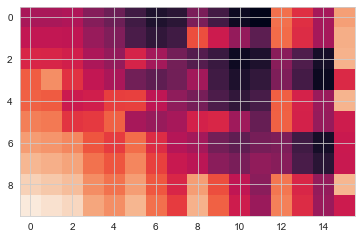

In [79]:

fig,ax = plt.subplots()
ax.imshow(X)
ax.set_aspect('equal')
